## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
!pip install imbalanced-learn --user


# this will help in making the Python code more structured automatically (good coding practice)
!pip install black[jupyter] --quiet

# to work with dataframes
import pandas as pd
import numpy as np
from numpy import array

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

custom = {"axes.edgecolor": "purple", "grid.linestyle": "solid", "grid.color": "black"}
sns.set_style("dark", rc=custom)

# to split data into train and test
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import metrics

# to build logstic regression model
from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# To impute missing values
from sklearn.impute import SimpleImputer

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# to impute missing values
from sklearn.impute import KNNImputer


# To build a decision tree model
from sklearn.tree import DecisionTreeClassifier

# To help with model building
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
    StackingClassifier,
    )

!pip install xgboost
from xgboost import XGBClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# To build a Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x) # to display percentages rounded off to 3 decimal places


# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


## Loading the dataset

In [2]:
# let colab access my google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
df_train = pd.read_csv("/content/drive/MyDrive/Python_Course/Project_6/Train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Python_Course/Project_6/Test.csv")

## Data Overview

- Observations
- Sanity checks

In [ ]:
df_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


### Understand the shape of the dataset.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

All features are Dtype float except the Target which has a Dtype of integer.

In [4]:
# Copy data to avoid any changes to original date
train = df_train.copy()
test = df_test.copy()

In [ ]:
# Use info() to print a concise summary of the DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

### Checking for duplicate values

In [ ]:
train.duplicated().sum()

0

In [ ]:
test.duplicated().sum()

0

### Checking for missing values

In [ ]:
train.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [ ]:
round(train.isnull().sum()/train.isnull().count() * 100, 2)

V1       0.090
V2       0.090
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

In [ ]:
# checking for unique values
train.nunique()

V1        19982
V2        19982
V3        20000
V4        20000
V5        20000
V6        20000
V7        20000
V8        20000
V9        20000
V10       20000
V11       20000
V12       20000
V13       20000
V14       20000
V15       20000
V16       20000
V17       20000
V18       20000
V19       20000
V20       20000
V21       20000
V22       20000
V23       20000
V24       20000
V25       20000
V26       20000
V27       20000
V28       20000
V29       20000
V30       20000
V31       20000
V32       20000
V33       20000
V34       20000
V35       20000
V36       20000
V37       20000
V38       20000
V39       20000
V40       20000
Target        2
dtype: int64

There are 36 missing values. Missing values are in V1 (18) and V2 (18). <br>
V1 and V2 are missing .09% of their values. <br>
All sensors except V1 and V2 have 20000 values in them.

In [ ]:
test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [ ]:
round(test.isnull().sum()/test.isnull().count() * 100, 2)

V1       0.100
V2       0.120
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

In [ ]:
# checking for unique values
test.nunique()

V1        4995
V2        4994
V3        5000
V4        5000
V5        5000
V6        5000
V7        5000
V8        5000
V9        5000
V10       5000
V11       5000
V12       5000
V13       5000
V14       5000
V15       5000
V16       5000
V17       5000
V18       5000
V19       5000
V20       5000
V21       5000
V22       5000
V23       5000
V24       5000
V25       5000
V26       5000
V27       5000
V28       5000
V29       5000
V30       5000
V31       5000
V32       5000
V33       5000
V34       5000
V35       5000
V36       5000
V37       5000
V38       5000
V39       5000
V40       5000
Target       2
dtype: int64

**Observations:**

V1 has 5 missing values .10% of their values and V2 has 6 missing values .12% of their values.<br>
No other sensors are missing values.

### Statistical summary

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


**Observations:**

The max between the features ranges from 5.671 and 17.560, excluding Target feature which is either 0 or 1. <br>
The mean between the features ranges from -3.611 to 2.485, excluding Target feature which is either 0 or 1. <br>
The std between the features frange from 1.652 and 4.369, excluding Target feature which is either 0 or 1.

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(data=train, x=feature, ax=ax_box2, showmeans=True, color="fuchsia", flierprops={'marker': 'o', 'markersize': 10, 'markerfacecolor': 'crimson', 'markeredgecolor':'purple'},
         capprops={'color': 'teal'}, whiskerprops={'color': 'turquoise'}, medianprops ={'color' : 'blue'}
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=train, x=feature, kde=kde, ax=ax_hist2, bins=bins, stat='density', line_kws={'color': 'fuchsia','lw': 5, 'ls': ':'}
    ) if bins else sns.histplot(
        data=train, x=feature, kde=kde, ax=ax_hist2, color="teal", ec="indigo"
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="crimson", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="purple", linestyle="-"
    )  # Add median to the histogram
    ax_hist2.lines[0].set_color('fuchsia')


### Plotting all the features at one go

In [15]:
for feature in train.columns:
    histogram_boxplot(train, feature, figsize=(12, 7), kde=True, bins=None)

Output hidden; open in https://colab.research.google.com to view.

**Observations:**

All the sensors are showing a normal distribution. There is a little bit of skewness on some of the sensors but not that much. <br>
The target has a bias of zero.

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top
    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """
    total = len(data[feature])  # length of the column
    count = data[feature].nunique()

    if n is None:
        plt.figure(figsize=(count + 1, 10))
    else:
        plt.figure(figsize=(n + 1, 10))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,  # Assign the x variable to hue
        palette="magma",  # Set the hue to the same variable
        legend=False,  # Disable the legend
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    # Annotate each bar with its count and percentage
    for p in ax.patches:
        prc = "{:.2f}%".format(100.0 * p.get_height() / total)  # percentage
        cnt = p.get_height()  # count
        xx = p.get_x() + p.get_width() / 2  # x coordinate of bar percentage label
        yy = p.get_height()  # y coordinate of bar percentage label

        # Annotate percentage
        ax.annotate(
            prc,
            (xx, yy),
            ha="center",
            va="center",
            style="italic",
            size=12,
            xytext=(0, 10),
            textcoords="offset points",
        )

        # Annotate count (adjust vertical position)
        ax.annotate(
            cnt,
            (xx, yy + 100),
            ha="center",
            va="bottom",  # Adjusted to display above the percentage label
            size=12,
            xytext=(0, 20),
            textcoords="offset points",
        )

    # Increase y-axis size by 500
    plt.ylim(0, ax.get_ylim()[1] + 500)

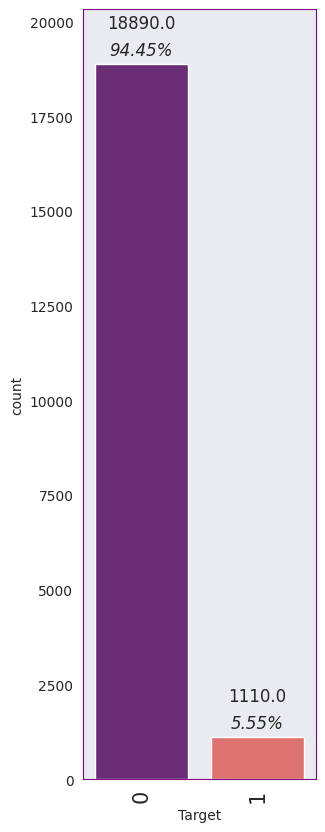

In [ ]:
# shows percentage of Target split in train data
labeled_barplot(train, "Target")

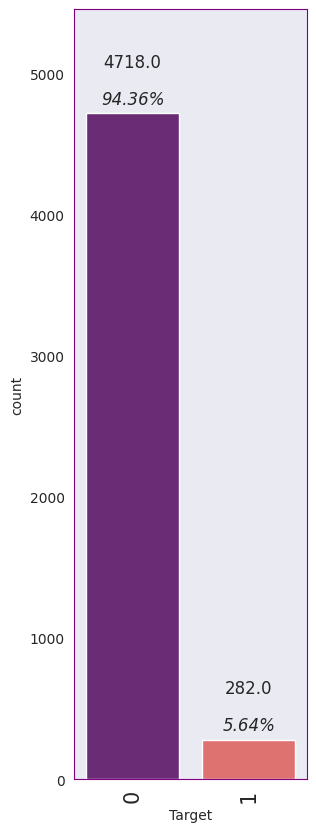

In [ ]:
# shows percentage of Target split in train data
labeled_barplot(test, "Target")

**Observations:**

Target for both test and train set has a 94% bias towards 0 or "not failure". Only 6% of both sets show 1 or "failure".

**Heat Map Correlation Plot**

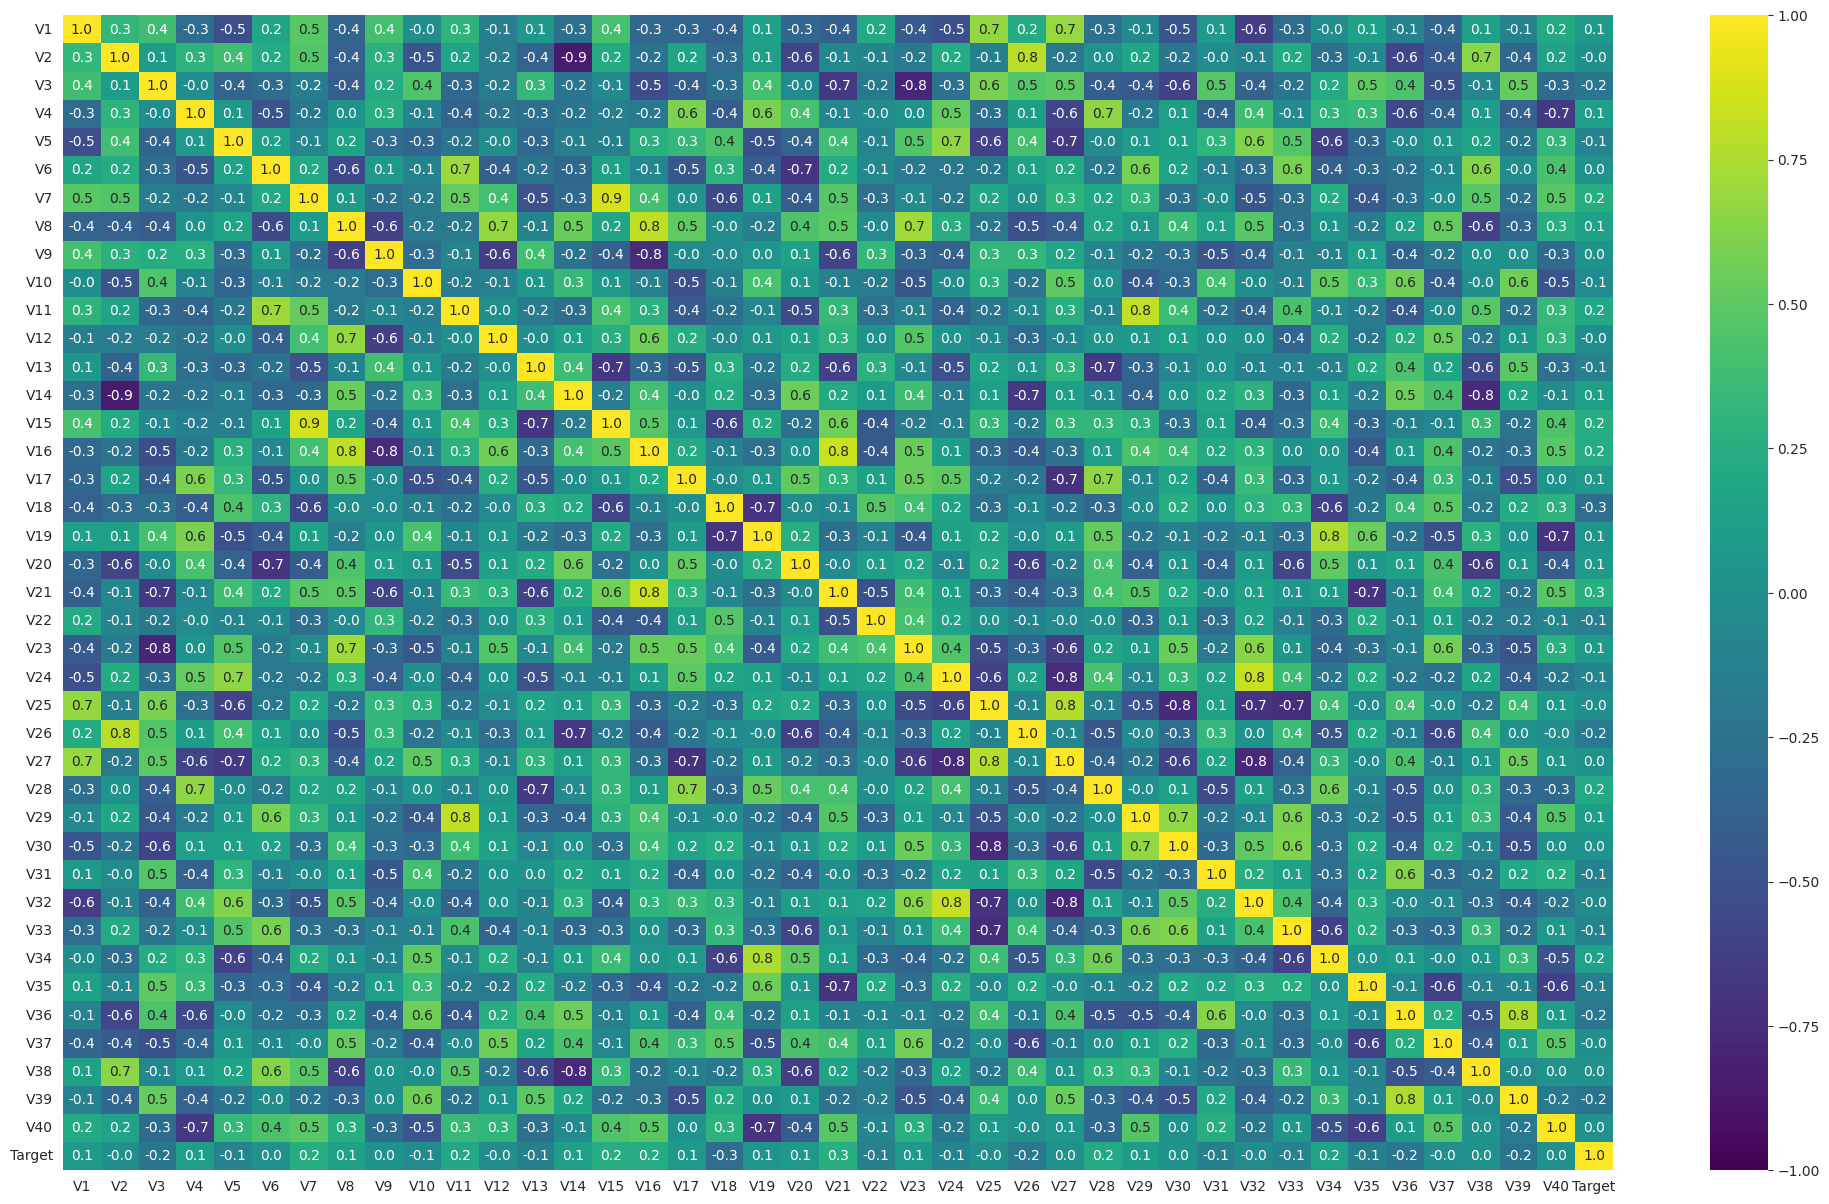

In [ ]:
plt.figure(figsize=(25, 15))  # sets size of heatmap
sns.heatmap(
    data=train.corr(), annot=True, fmt=".1f", vmin=-1, vmax=1, cmap="viridis"
)  # creates heatmap of correlation in the train data set
plt.show()

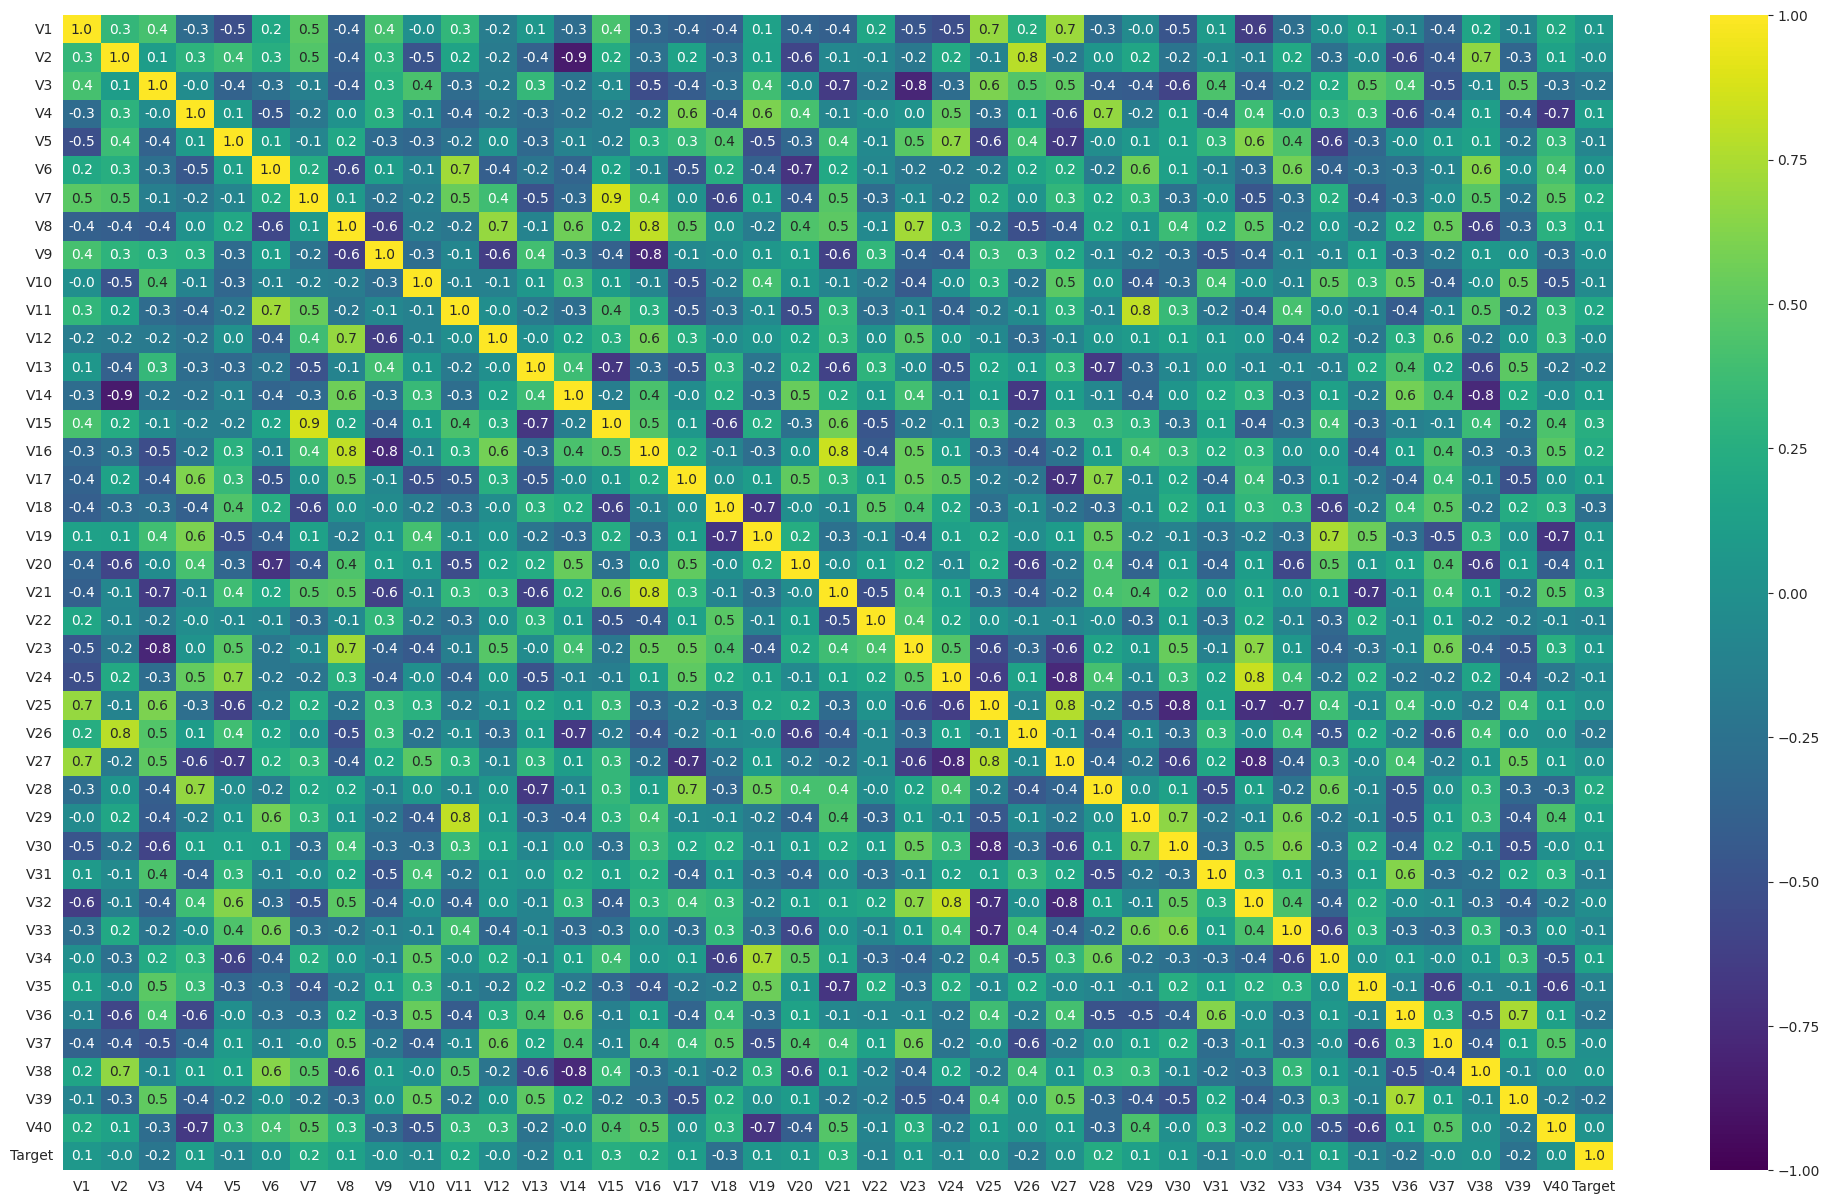

In [ ]:
plt.figure(figsize=(25, 15))  # sets size of heatmap
sns.heatmap(
    data=test.corr(), annot=True, fmt=".1f", vmin=-1, vmax=1, cmap="viridis"
)  # creates heatmap of correlation in the train data set
plt.show()

**Observations:**

* The train and test datasets were divided effectively.
* The exploratory data analysis (EDA) reveals consistent patterns across both the train and test datasets.
* The heatmaps demonstrate correlations among various sensors.

## Data Pre-processing

In [ ]:
train1 = train.copy()
test1 = test.copy()

In [ ]:
# prepare my data for the test train split. this includes the test dataset and the train dataset
X = train1.drop("Target", axis=1)
y = train1["Target"]

X_test = test1.drop("Target", axis=1)
y_test = test1["Target"]

In [ ]:
# splits the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

In [ ]:
# prints shape of X_train, X_val, and X_test sets
print("X_train shape - ", X_train.shape)
print("X_val shape - ", X_val.shape)
print("X_test shape - ", X_test.shape)

X_train shape -  (15000, 40)
X_val shape -  (5000, 40)
X_test shape -  (5000, 40)


Made a copy so there was a backup of the file. <br>
Made adjustments to the copy. Removed the Target and split the data into test file and validation.


## Missing value imputation




* We will use KNN imputer to impute missing values.
* `KNNImputer`: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.
* For each data point with missing values, the KNNImputer finds the k nearest neighbors in the dataset.
* KNN imputer replaces missing values using the average of k nearest non-missing feature values.
* Nearest points are found based on euclidean distance.


In [ ]:
# sets the imputer as the KNNImputer using the 10 nearest neighbors to the data point.
imputer = KNNImputer(n_neighbors=10)

# normalizes data for KNNImputer to accuratly impute missing values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)


In [ ]:
# prints missing values of X_train, X_val, and X_test sets
# 2 sensors had missing values V1 and V2
print(X_train.isna().sum()[:2], "\n", 50 * "-")
print(X_val.isna().sum()[:2], "\n", 50 * "-")
print(X_test.isna().sum()[:2], "\n", 50 * "-")

V1    15
V2    14
dtype: int64 
 --------------------------------------------------
V1    3
V2    4
dtype: int64 
 --------------------------------------------------
V1    5
V2    6
dtype: int64 
 --------------------------------------------------


In [ ]:
# use the imputer to fit to X_train and then transform the missing values using KNNImputer
X_train_scaled = imputer.fit_transform(X_train_scaled)

# use the imputer to fit to X_val and then transform the missing values using KNNImputer
X_val_scaled = imputer.fit_transform(X_val_scaled)

# use the imputer to fit to X_test and then transform the missing values using KNNImputer
X_test_scaled = imputer.fit_transform(X_test_scaled)

# turns it from array back to a dataframe
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# turns it from array back to a dataframe
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# turns it from array back to a dataframe
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# prints missing values of X_train, X_val, and X_test sets
# 2 sensors had missing values V1 and V2
print(X_train.isna().sum()[:2], "\n", 50 * "-")
print(X_val.isna().sum()[:2], "\n", 50 * "-")
print(X_test.isna().sum()[:2], "\n", 50 * "-")

V1    0
V2    0
dtype: int64 
 --------------------------------------------------
V1    0
V2    0
dtype: int64 
 --------------------------------------------------
V1    0
V2    0
dtype: int64 
 --------------------------------------------------


V1 and V2's missing values have now been updated. They were updated using KNN imputer with a nearest neighbors of 10.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- Repair Cost - True positives (TP) are failures correctly predicted by the model.
- Replacement Cost - False negatives (FN) are real failures in a generator where there is no detection by model.
- Inspection Cost - False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.
* The objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost. <br>
* We aim to minimize maintenance costs relative to the associated model costs. This approach ensures efficient asset management while controlling expenses. <br>
* The minimum possible maintenance cost = Actual failures*(Repair cost) = (TP + FN)*(Repair cost) <br>
* The maintenance cost associated with model = TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost ) <br>
* Our model needs to minimize costs.




**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
             },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="",cmap='cool')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

**Let's start by building different models using KFold and cross_val_score and tune the best model using GridSearchCV and RandomizedSearchCV**

- `Stratified K-Folds cross-validation` provides dataset indices to split data into train/validation sets. Split dataset into k consecutive folds (without shuffling by default) keeping the distribution of both classes in each fold the same as the target variable. Each fold is then used once as validation while the k - 1 remaining folds form the training set.

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("GBoost", GradientBoostingClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("DTree", DecisionTreeClassifier(random_state=1)))
models.append(("LogRegression", LogisticRegression(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Bagging: 72.1080730106053
Random Forest: 72.35192266070268
GBoost: 70.66661857008873
AdaBoost: 63.09140754635308
XGBoost: 81.60450183969411
DTree: 69.82829521679533
LogRegression: 45.06889834788256

Validation Performance:

Bagging: 0.737410071942446
Random Forest: 0.7661870503597122
GBoost: 0.7517985611510791
AdaBoost: 0.6870503597122302
XGBoost: 0.8093525179856115
DTree: 0.7230215827338129
LogRegression: 0.46402877697841727


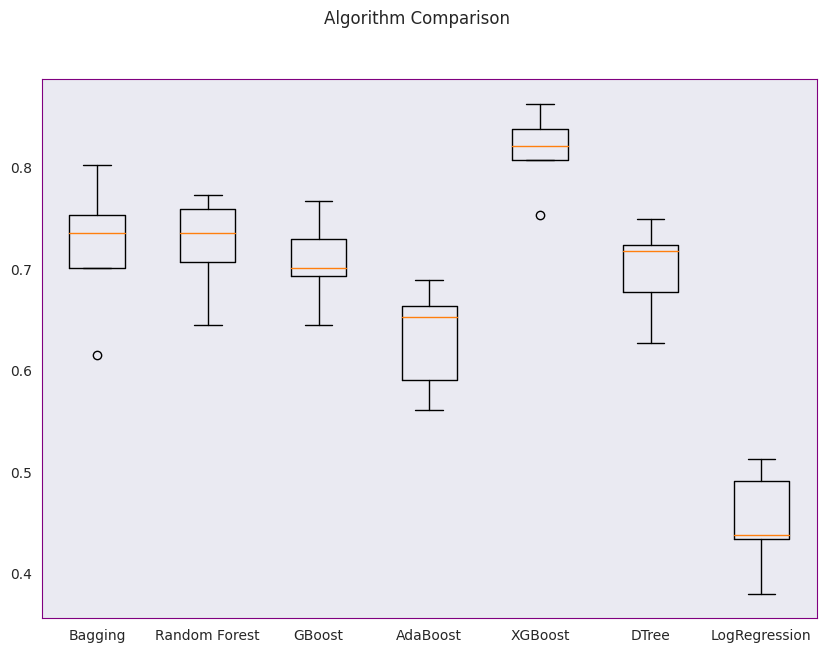

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

**Observations:**

* Top Order (based on training):
    1. XGBoost 81.60%
    2. Random Forest 72.35%
    3. Bagging 72.11%
    4. GBoost 70.67%
    5. DTree 69.83%
    6. AdaBoost 63.09%
    7. LogRegression 45.07%

* Top Order (based on validation):
    1. XGBoost 80.94%
    2. Random Forest 76.62%
    3. GBoost 75.18%
    4. Bagging 73.74%
    5. DTree 72.30%
    6. AdaBoost 68.71%
    7. LogRegression 46.40%

* Top 3 based on training and testing is XGBoost, Random Forest and GBoost.
* The recall scores are ok for the top 3 but they can definitely be improved.


### Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [ ]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("DTree_over", DecisionTreeClassifier(random_state=1)))
models_over.append(("GBoost_over", GradientBoostingClassifier(random_state=1)))
models_over.append(("AdaBoost_over", AdaBoostClassifier(random_state=1)))
models_over.append(("Bagging_over", BaggingClassifier(random_state=1)))
models_over.append(("Random_Forest_over", RandomForestClassifier(random_state=1)))
models_over.append(("LogRegression_over", LogisticRegression(random_state=1)))
models_over.append(("XGBoost_over", XGBClassifier(disable_default_eval_metric=True, random_state=1))
)

results2 = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance on Oversampled Data:" "\n")

for name, model in models_over:
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results2.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance on Oversampled Data:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Performance on Oversampled Data:

DTree_over: 0.9705674452297639
GBoost_over: 0.9244069479551043
AdaBoost_over: 0.8963857261467018
Bagging_over: 0.9762138731419521
Random_Forest_over: 0.9818606747126131
LogRegression_over: 0.8845988440003278
XGBoost_over: 0.9893420895629467

Validation Performance on Oversampled Data:

DTree_over: 0.6510791366906474
GBoost_over: 0.8381294964028777
AdaBoost_over: 0.8093525179856115
Bagging_over: 0.7266187050359713
Random_Forest_over: 0.7949640287769785
LogRegression_over: 0.8345323741007195
XGBoost_over: 0.8273381294964028


**Observations:**

* Top Order (based on training):
    1. XGBoost 98.93%
    2. Random Forrest 98.19%
    3. Bagging 97.62%
    4. DTree 97.06%
    5. GBoost 92.44%
    6. AdaBoost 89.64%
    7. LogRegression 88.46%
  
* Top Order (based on validation):
    1. GBoost 83.81%
    2. LogRegression 83.45%
    3. XGBoost 82.73%
    4. AdaBoost 80.94%
    5. Random Forrest 79.50%
    6. Bagging 72.66%
    7. DTree 65.11%


* Top order based on training and validation is vastly different. Going strictly off validation, top 3 is GBoost, LogRegression and XG Boost.
* The recall scores are ok but they can be improved.



### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))

print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



In [ ]:
models_un = []  # Empty list to store all the models

# Appending models into the list
models_un.append(("DTree_under", DecisionTreeClassifier(random_state=1)))
models_un.append(("GBoost_under", GradientBoostingClassifier(random_state=1)))
models_un.append(("AdaBoost_under", AdaBoostClassifier(random_state=1)))
models_un.append(("Bagging_under", BaggingClassifier(random_state=1)))
models_un.append(("Random_Forest_under", RandomForestClassifier(random_state=1)))
models_un.append(("LogRegression_under", LogisticRegression(random_state=1)))
models_un.append(
    ("XGBoost_under", XGBClassifier(disable_default_eval_metric=True, random_state=1))
)

results3 = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance on Undersampled Data:" "\n")

for name, model in models_un:
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results3.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance on Undersampled Data:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Performance on Undersampled Data:

DTree_under: 0.8617776495202367
GBoost_under: 0.8990621167303946
AdaBoost_under: 0.8666113556020489
Bagging_under: 0.8641945025611427
Random_Forest_under: 0.9038669648654498
LogRegression_under: 0.8690065651828872
XGBoost_under: 0.9002741504941923

Validation Performance on Undersampled Data:

DTree_under: 0.7805755395683454
GBoost_under: 0.8812949640287769
AdaBoost_under: 0.8381294964028777
Bagging_under: 0.8597122302158273
Random_Forest_under: 0.8812949640287769
LogRegression_under: 0.841726618705036
XGBoost_under: 0.8848920863309353


**Observations:**

* Top Order (based on training performance):
    1. Random Forrest 90.39%
    2. XGBoost 90.02%
    3. GBoost 89.91%
    4. LogRegression 86.91%
    5. AdaBoost 86.66%
    6. Bagging 86.42%
    7. DTree 86.18%

* Top Order (based on validation performance):
    1. XGBoost 88.49%
    2. GBoost 88.13%
    3. Random Forrest 88.13%
    4. Bagging 85.97%
    5. LogRegression 84.17%
    6. AdaBoost 83.81%
    7. DTree 78.06%

* Top 3 are Random Forrest, XG Boost and GBoost in training and validation.

* The recall scores are ok but they can be improved.

## HyperparameterTuning

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

Going to tune Gradient Boost, XG Boost, and Random Forest. These models had the highest validations on the original data, oversampling and undersampling.

### Sample tuning method for Random Forest with original data

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6984272419017385:


In [ ]:
# building model with best parameters
Random_Forest_tuned = RandomForestClassifier(
    n_estimators= 300,
    min_samples_leaf= 1,
    max_samples= 0.6,
    max_features= 'sqrt',
)

# Fit the model on training data
Random_Forest_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=300)

In [ ]:
## To check the performance on training set
Random_Forest_random_train = model_performance_classification_sklearn(
    Random_Forest_tuned, X_train, y_train
)
Random_Forest_random_train

,Accuracy,Recall,Precision,F1
0,0.9949,0.9087,1.0000,0.9521


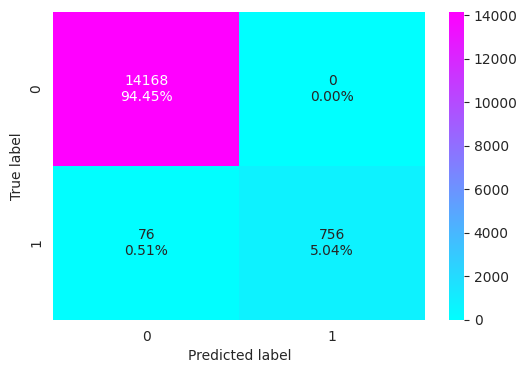

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned, X_train, y_train)

In [ ]:
## To check the performance on validation set
Random_Forest_random_val = model_performance_classification_sklearn(
    Random_Forest_tuned, X_val, y_val
)
Random_Forest_random_val

,Accuracy,Recall,Precision,F1
0,0.9860,0.7626,0.9815,0.8583


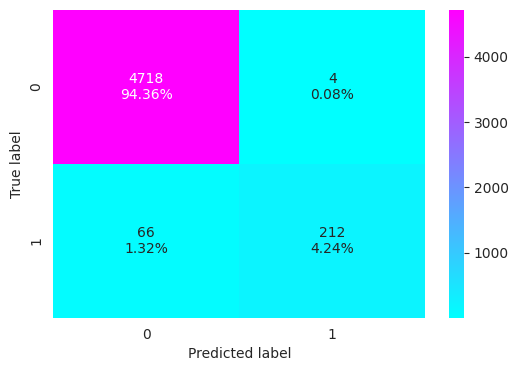

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned, X_val, y_val)

Training - There is overfitting  precision is 100% and Accuracy is 99.49%.<br>
Validation - Recall rate is 76.26 but all other rates are good. Recall can be improved.

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = {"n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling GriddSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Best parameters are {'max_features': array([0.3, 0.4, 0.5]), 'max_samples': 0.4, 'min_samples_leaf': 1, 'n_estimators': 250} with CV score=0.8125532068393333:


In [ ]:
# Define the array of max_features
max_features_array = [0.3, 0.4, 0.5]

# Loop through each value in the array and build a model
for max_feature in max_features_array:
    Random_Forest_tuned_grid = RandomForestClassifier(
        n_estimators=250,
        min_samples_leaf=1,
        max_samples=0.4,
        max_features=max_feature
    )

# Fit the model on training data
Random_Forest_tuned_grid.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, max_samples=0.4, n_estimators=250)

In [ ]:
## To check the performance on training set
Random_Forest_grid_train = model_performance_classification_sklearn(
    Random_Forest_tuned_grid, X_train, y_train
)
Random_Forest_grid_train

,Accuracy,Recall,Precision,F1
0,0.9906,0.8341,0.9957,0.9078


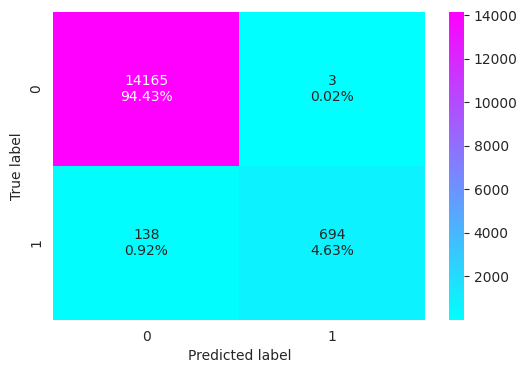

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
Random_Forest_grid_val = model_performance_classification_sklearn(
    Random_Forest_tuned_grid, X_val, y_val
)
Random_Forest_grid_val

,Accuracy,Recall,Precision,F1
0,0.9860,0.7770,0.9643,0.8606


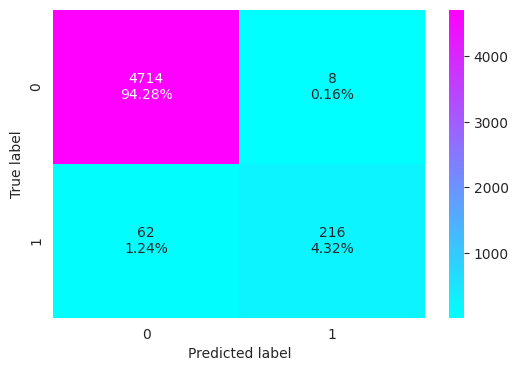

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_grid, X_val, y_val)

Training - There is overfitting  precision is 99.57% and Accuracy is 99.06%.<br>
Validation - Recall rate is 77.70 but all other rates are good. Recall can be improved. Accuracy is a little overfitted.

### Sample tuning method for Gradient Boost with original data

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7572685953394416:


In [ ]:
# building model with best parameters
GB_tuned = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= 125,
    max_features= 0.5,
    learning_rate= 0.2,
)

# Fit the model on training data
GB_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [ ]:
## To check the performance on validation set
GB_random_train = model_performance_classification_sklearn(
    GB_tuned, X_train, y_train
)
GB_random_train

,Accuracy,Recall,Precision,F1
0,0.9927,0.9087,0.9570,0.9322


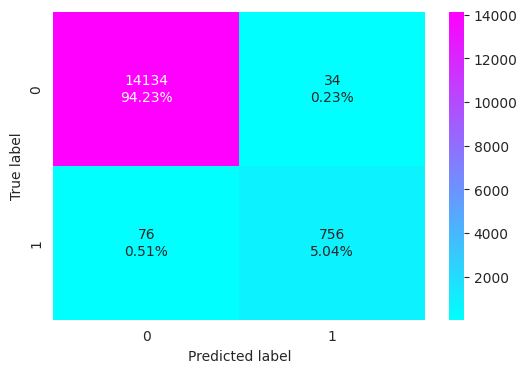

In [ ]:
confusion_matrix_sklearn(GB_tuned, X_train, y_train)

In [ ]:
## To check the performance on validation set
GB_random_val = model_performance_classification_sklearn(
    GB_tuned, X_val, y_val
)
GB_random_val

,Accuracy,Recall,Precision,F1
0,0.9734,0.7374,0.7736,0.7551


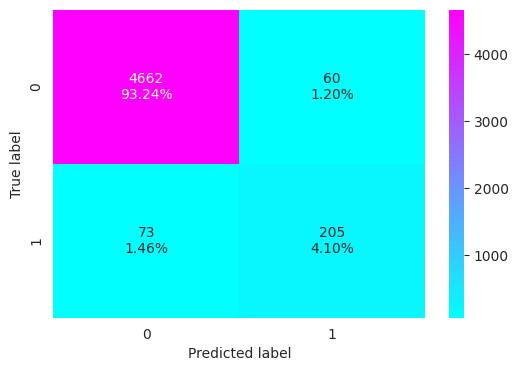

In [ ]:
confusion_matrix_sklearn(GB_tuned, X_val, y_val)

Train -The Recall score is 90.87%, there is most likely overfitting since Accuracy is 99.27% and Precision is 95.7%. <br>
Validation - Recall rate could be improved but is not bad, it is 73.74%. Accuracy which is 97.34%.

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling GridCSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

#Fitting parameters in GridCSearchCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_, grid_cv.best_score_))

Best parameters are {'learning_rate': 0.2, 'max_features': 0.5, 'n_estimators': 125, 'subsample': 0.7} with CV score=0.8017386912921147:


In [ ]:
# building model with best parameters
GB_tuned_grid = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= 125,
    max_features= 0.5,
    learning_rate= 0.2,
)

# Fit the model on training data
GB_tuned_grid.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [ ]:
## To check the performance on training set
GB_grid_train = model_performance_classification_sklearn(
    GB_tuned_grid, X_train, y_train
)
GB_grid_train

,Accuracy,Recall,Precision,F1
0,0.9945,0.9147,0.9845,0.9483


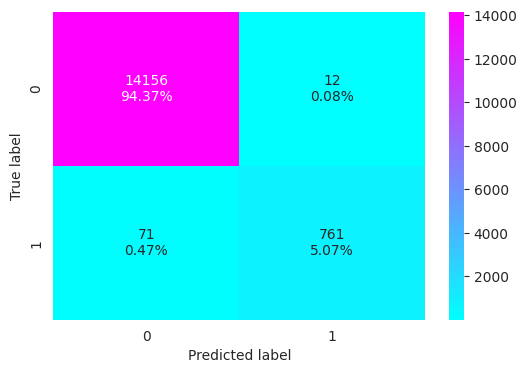

In [ ]:
confusion_matrix_sklearn(GB_tuned_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
GB_grid_val = model_performance_classification_sklearn(
    GB_tuned_grid, X_val, y_val
)
GB_grid_val

,Accuracy,Recall,Precision,F1
0,0.9722,0.7554,0.7473,0.7513


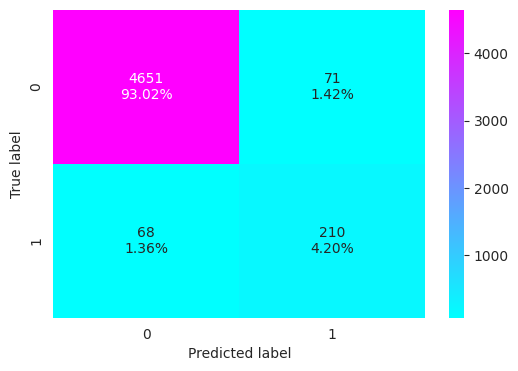

In [ ]:
confusion_matrix_sklearn(GB_tuned_grid, X_val, y_val)

Train -The Recall score is 91.47%, there is most likely overfitting since Accuracy is 99.45% and Precision is 98.45%. <br>
Validation - Recall rate could be improved but is not bad, it is 75.54%. Precision and F1 rates are lower at 74.73% and 75.13%. Accuracy has a rate of 97.22%.

### Sample tuning method for XG Boost with original data

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.8582136930957361:


In [ ]:
# building model with best parameters
XGB_tuned = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight = 10,
    n_estimators= 200,
    learning_rate= 0.1,
    gamma= 3
   )

# Fit the model on training data
XGB_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## To check the performance on training set
XGB_random_train = model_performance_classification_sklearn(
    XGB_tuned, X_train, y_train
)
XGB_random_train

,Accuracy,Recall,Precision,F1
0,0.9993,1.0000,0.9870,0.9934


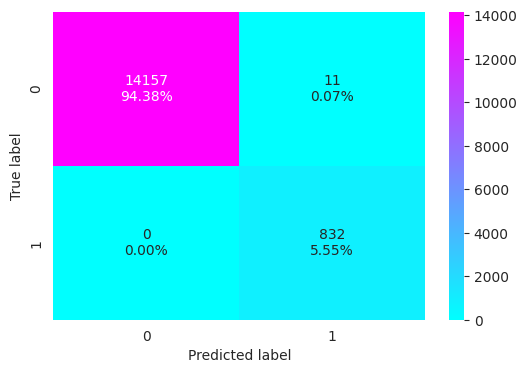

In [ ]:
confusion_matrix_sklearn(XGB_tuned, X_train, y_train)

In [ ]:
## To check the performance on validation set
XGB_random_val = model_performance_classification_sklearn(
    XGB_tuned, X_val, y_val
)
XGB_random_val

,Accuracy,Recall,Precision,F1
0,0.9872,0.8058,0.9573,0.8750


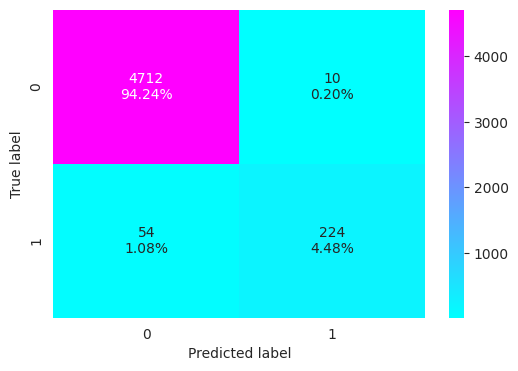

In [ ]:
confusion_matrix_sklearn(XGB_tuned, X_val, y_val)

Train - Original Data is overfit. Everything ranges from 98.7% to 100%.<br>
Validation - Rates are all good. Accuracy might have some overfitting but rest of the rates look good.

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling GridCSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

#Fitting parameters in GridCSearchCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_, grid_cv.best_score_))

Best parameters are {'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'scale_pos_weight': 10, 'subsample': 0.9} with CV score=0.8582136930957361:


In [ ]:
# building model with best parameters
XGB_tuned_grid = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight = 10,
    n_estimators= 200,
    learning_rate= 0.1,
    gamma= 3
   )

# Fit the model on training data
XGB_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## To check the performance on training set
XGB_grid_train = model_performance_classification_sklearn(
    XGB_tuned_grid, X_train, y_train
)
XGB_grid_train

,Accuracy,Recall,Precision,F1
0,0.9993,1.0000,0.9870,0.9934


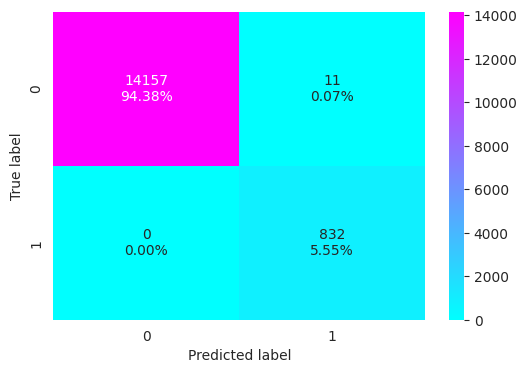

In [ ]:
confusion_matrix_sklearn(XGB_tuned_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
XGB_grid_val = model_performance_classification_sklearn(
    XGB_tuned_grid, X_val, y_val
)
XGB_grid_val

,Accuracy,Recall,Precision,F1
0,0.9872,0.8058,0.9573,0.8750


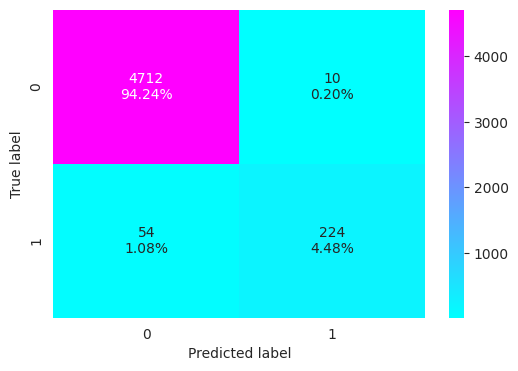

In [ ]:
confusion_matrix_sklearn(XGB_tuned_grid, X_val, y_val)

Train - Original Data is overfit. Everything ranges from 98.7% to 100%.<br>
Validation - Rates are all good. Accuracy might have some overfitting but rest of the rates look good.

### Sample tuning method for Random Forest with oversampled data

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9808017764222002:


In [ ]:
# building model with best parameters
Random_Forest_tuned_over = RandomForestClassifier(
    n_estimators= 250,
    min_samples_leaf= 1,
    max_samples= 0.6,
    max_features= 'sqrt',
)

# Fit the model on training data
Random_Forest_tuned_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=250)

In [ ]:
## To check the performance on training set
Random_Forest_random_train_over = model_performance_classification_sklearn(
    Random_Forest_tuned_over, X_train, y_train
)
Random_Forest_random_train_over

,Accuracy,Recall,Precision,F1
0,0.9999,1.0000,0.9988,0.9994


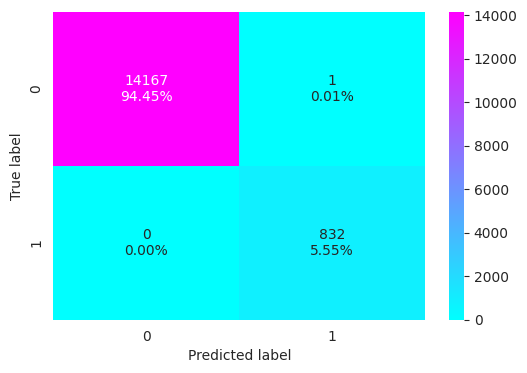

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_over, X_train, y_train)

In [ ]:
## To check the performance on validation set
Random_Forest_random_val_over = model_performance_classification_sklearn(
    Random_Forest_tuned_over, X_val, y_val
)
Random_Forest_random_val_over

,Accuracy,Recall,Precision,F1
0,0.9880,0.8094,0.9698,0.8824


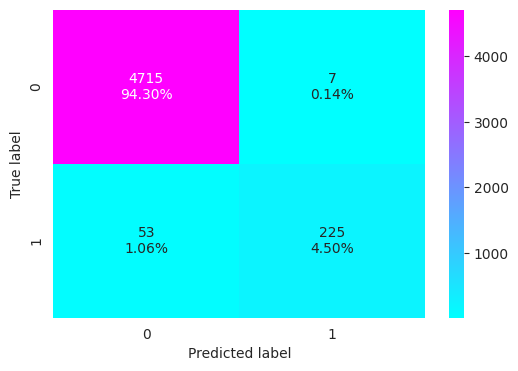

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_over, X_val, y_val)

Train - Even more overfit than the original. <br>
Validation - Not as overfit as the training but Accuracy and Precision are still showing overfitting.

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

#Fitting parameters in GridCSearchCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_, grid_cv.best_score_))

Best parameters are {'max_features': array([0.3, 0.4, 0.5]), 'max_samples': 0.4, 'min_samples_leaf': 1, 'n_estimators': 250} with CV score=0.8125532068393333:


In [ ]:
# Define the array of max_features
max_features_array = [0.3, 0.4, 0.5]

# Loop through each value in the array and build a model
for max_feature in max_features_array:
    Random_Forest_tuned_over_grid = RandomForestClassifier(
        n_estimators=250,
        min_samples_leaf=1,
        max_samples=0.4,
        max_features=max_feature
    )

# Fit the model on training data
Random_Forest_tuned_over_grid.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features=0.5, max_samples=0.4, n_estimators=250)

In [ ]:
## To check the performance on validation set
Random_Forest_grid_train_over = model_performance_classification_sklearn(
    Random_Forest_tuned_over_grid, X_train, y_train
)
Random_Forest_grid_train_over

,Accuracy,Recall,Precision,F1
0,0.9983,0.9988,0.9719,0.9852


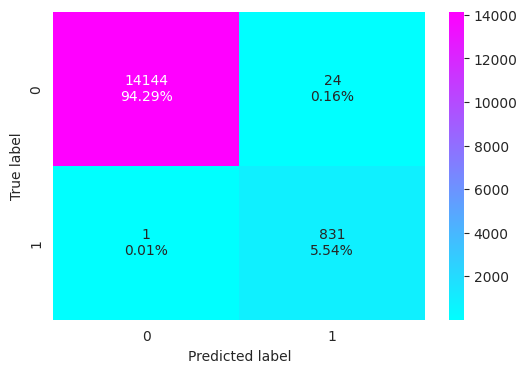

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_over_grid, X_train, y_train)

In [ ]:
## To check the performance on training set
Random_Forest_grid_val_over = model_performance_classification_sklearn(
    Random_Forest_tuned_over_grid, X_val, y_val
)
Random_Forest_grid_val_over

,Accuracy,Recall,Precision,F1
0,0.9868,0.8237,0.9309,0.8740


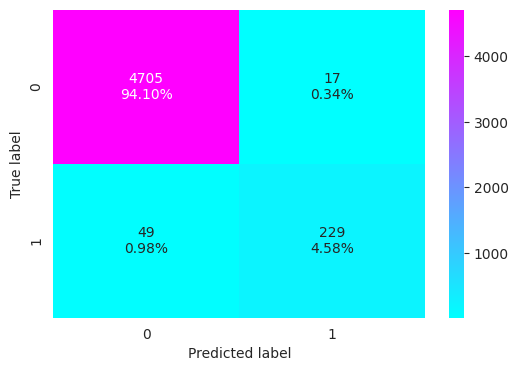

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_over_grid, X_val, y_val)

Train - Even more overfit than the original. <br>
Validation - Not as overfit as the training but Accuracy is still showing overfitting.

### Sample tuning method for Gradient Boost with oversampled data

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 1} with CV score=0.9698622520495789:


In [ ]:
# building model with best parameters
GB_tuned_over = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= 125,
    max_features= 0.7,
    learning_rate= 1,
)

# Fit the model on training data
GB_tuned_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.7, n_estimators=125,
                           subsample=0.7)

In [ ]:
## To check the performance on training set
GB_random_train_over = model_performance_classification_sklearn(
    GB_tuned_over, X_train, y_train
)
GB_random_train_over

,Accuracy,Recall,Precision,F1
0,0.9941,0.9976,0.9051,0.9491


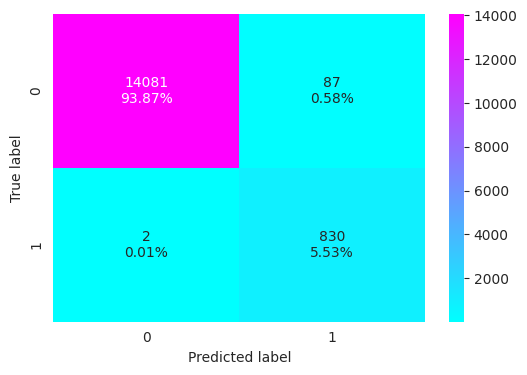

In [ ]:
confusion_matrix_sklearn(GB_tuned_over, X_train, y_train)

In [ ]:
## To check the performance on validation set
GB_random_val_over = model_performance_classification_sklearn(
    GB_tuned_over, X_val, y_val
)
GB_random_val_over

,Accuracy,Recall,Precision,F1
0,0.9696,0.8022,0.6969,0.7458


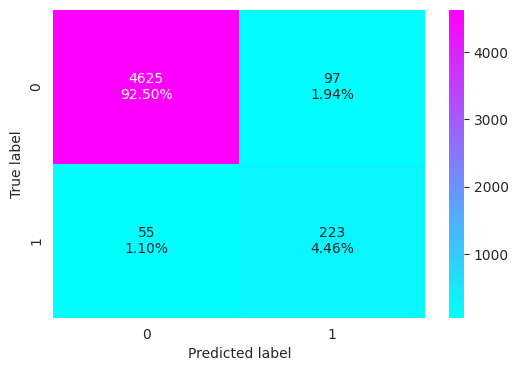

In [ ]:
confusion_matrix_sklearn(GB_tuned_over, X_val, y_val)

Train - There is overfitting in both Accuracy and Recall. Precision rates and F1 rates are good. <br>
Validation - Recall is 80.22% is ok and the Precision has a rate of 69.69%.

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters are {'learning_rate': 0.2, 'max_features': 0.5, 'n_estimators': 125, 'subsample': 0.7} with CV score=0.8017386912921147:


In [ ]:
# building model with best parameters
GB_tuned_over_grid = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= 125,
    max_features= 0.5,
    learning_rate= 0.2,
)

# Fit the model on training data
GB_tuned_over_grid.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [ ]:
## To check the performance on training set
GB_grid_train_over = model_performance_classification_sklearn(
    GB_tuned_over_grid, X_train, y_train
)
GB_grid_train_over

,Accuracy,Recall,Precision,F1
0,0.9855,0.9483,0.8185,0.8786


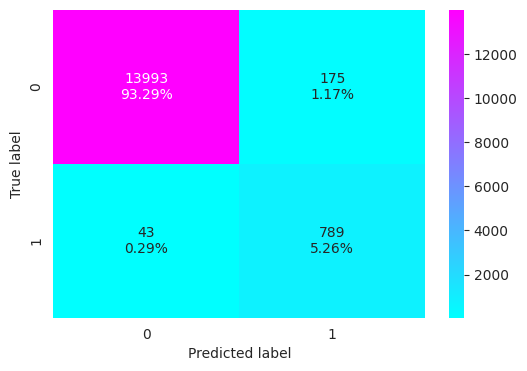

In [ ]:
confusion_matrix_sklearn(GB_tuned_over_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
GB_grid_val_over = model_performance_classification_sklearn(
    GB_tuned_over_grid, X_val, y_val
)
GB_grid_val_over

,Accuracy,Recall,Precision,F1
0,0.9798,0.8381,0.8062,0.8219


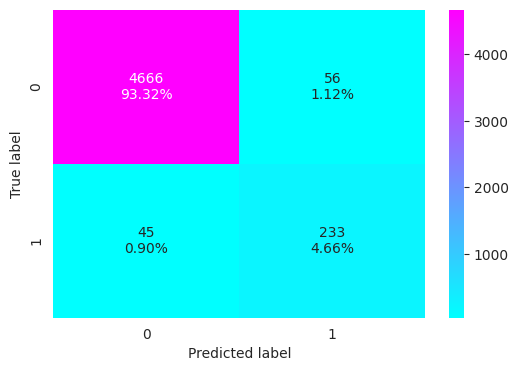

In [ ]:
confusion_matrix_sklearn(GB_tuned_over_grid, X_val, y_val)

Train - There is a little overfitting in Accuracy. The rest of the rates are good. <br>
Validation - Recall is 83.81% which is ok and the Precision has a rate of 80.62%.

### Sample tuning method for XG Boost with oversampled data

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9954827929027807:


In [ ]:
# building model with best parameters
XGB_tuned_over = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight = 10,
    n_estimators= 150,
    learning_rate= 0.2,
    gamma= 0
)

# Fit the model on training data
XGB_tuned_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## To check the performance on training set
XGB_random_train_over = model_performance_classification_sklearn(
    XGB_tuned_over, X_train, y_train
)
XGB_random_train_over

,Accuracy,Recall,Precision,F1
0,1.000,1.000,0.995,0.998


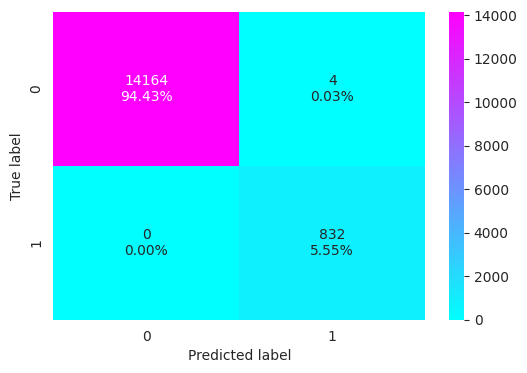

In [ ]:
confusion_matrix_sklearn(XGB_tuned_over, X_train, y_train)

In [ ]:
## To check the performance on validation set
XGB_random_val_over = model_performance_classification_sklearn(
    XGB_tuned_over, X_val, y_val
)
XGB_random_val_over

,Accuracy,Recall,Precision,F1
0,0.986,0.817,0.927,0.868


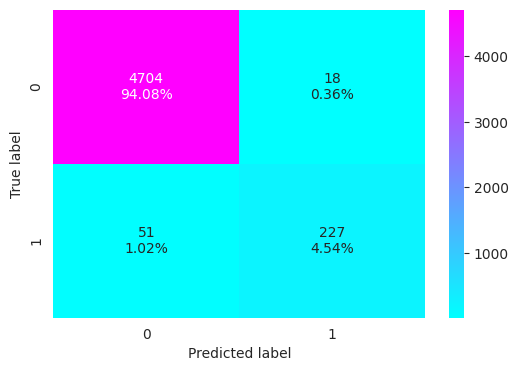

In [ ]:
confusion_matrix_sklearn(XGB_tuned_over, X_val, y_val)

Train - Overfitting in all rates. <br>
Validation - Accuracy is showing some overfitting the rest of the rates are good.

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters are {'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'scale_pos_weight': 10, 'subsample': 0.9} with CV score=0.8582136930957361:


In [ ]:
# building model with best parameters
XGB_tuned_over_grid = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight = 10,
    n_estimators= 200,
    learning_rate= 0.1,
    gamma= 3
)

# Fit the model on training data
XGB_tuned_over_grid.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## To check the performance on training set
XGB_grid_train_over = model_performance_classification_sklearn(
    XGB_tuned_over_grid, X_train, y_train
)
XGB_grid_train_over

,Accuracy,Recall,Precision,F1
0,0.9926,1.0000,0.8823,0.9375


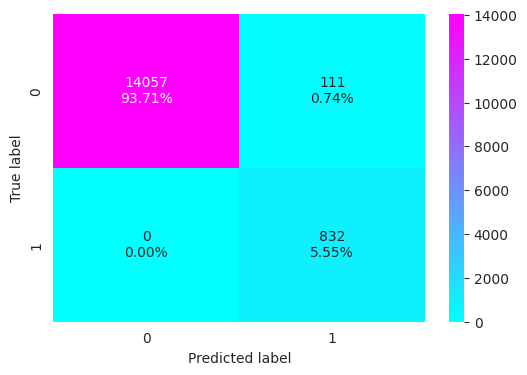

In [ ]:
confusion_matrix_sklearn(XGB_tuned_over_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
XGB_grid_val_over = model_performance_classification_sklearn(
    XGB_tuned_over_grid, X_val, y_val
)
XGB_grid_val_over

,Accuracy,Recall,Precision,F1
0,0.9838,0.8489,0.8582,0.8535


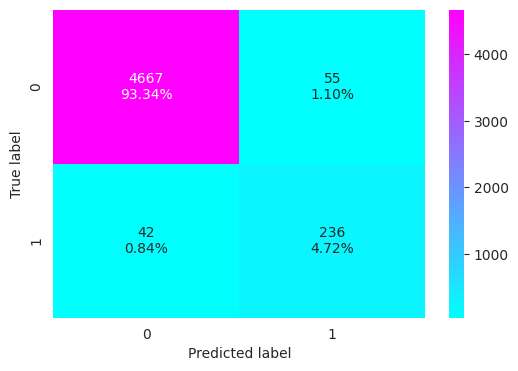

In [ ]:
confusion_matrix_sklearn(XGB_tuned_over_grid, X_val, y_val)

Training - Accuracy and Recall are both overfitted. Other rates are good. <br>
Validation - Accuracy showing some overfitting. Other rates are good.

### Sample tuning method for Random Forest with undersampled data

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990188298102589:


In [ ]:
# building model with best parameters
Random_Forest_tuned_under = RandomForestClassifier(
    n_estimators= 300,
    min_samples_leaf= 2,
    max_samples= 0.5,
    max_features= 'sqrt',
)

# Fit the model on training data
Random_Forest_tuned_under.fit(X_train_un,y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300)

In [ ]:
## To check the performance on training set
Random_Forest_random_train_under = model_performance_classification_sklearn(
    Random_Forest_tuned_under, X_train, y_train
)
Random_Forest_random_train_under

,Accuracy,Recall,Precision,F1
0,0.9460,0.9339,0.5072,0.6574


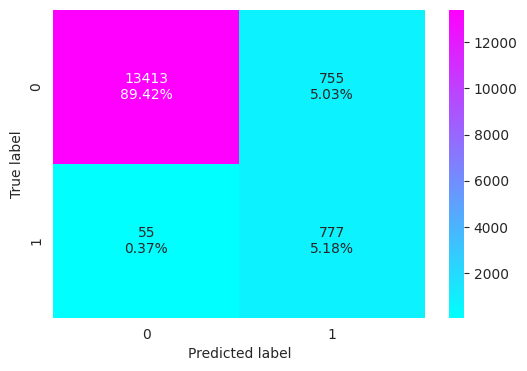

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_under, X_train, y_train)

In [ ]:
## To check the performance on validation set
Random_Forest_random_val_under = model_performance_classification_sklearn(
    Random_Forest_tuned_under, X_val, y_val
)
Random_Forest_random_val_under

,Accuracy,Recall,Precision,F1
0,0.9440,0.8777,0.4980,0.6354


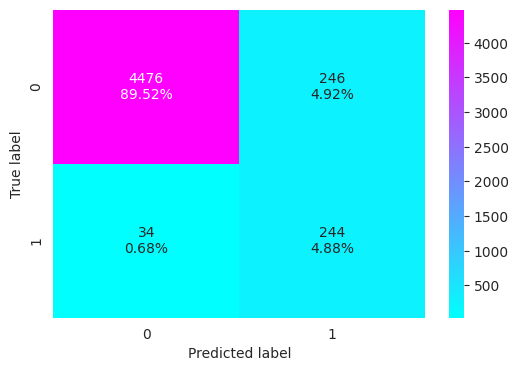

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_under, X_val, y_val)

Train - Recall rate is good but Precision is very low, only 50.72%. <br>
Validation - Recall rate is good but Precision is very low, only 49.80%.

In [ ]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters are {'max_features': array([0.3, 0.4, 0.5]), 'max_samples': 0.4, 'min_samples_leaf': 1, 'n_estimators': 250} with CV score=0.8125532068393333:


In [ ]:
# building model with best parameters
Random_Forest_tuned_under_grid = RandomForestClassifier(
    n_estimators= 250,
    min_samples_leaf= 2,
    max_samples= 0.5,
    max_features= 'sqrt',
)

# Fit the model on training data
Random_Forest_tuned_under_grid.fit(X_train_un,y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=250)

In [ ]:
## To check the performance on training set
Random_Forest_grid_train_under = model_performance_classification_sklearn(
    Random_Forest_tuned_under_grid, X_train, y_train
)
Random_Forest_grid_train_under

,Accuracy,Recall,Precision,F1
0,0.9478,0.9327,0.5163,0.6647


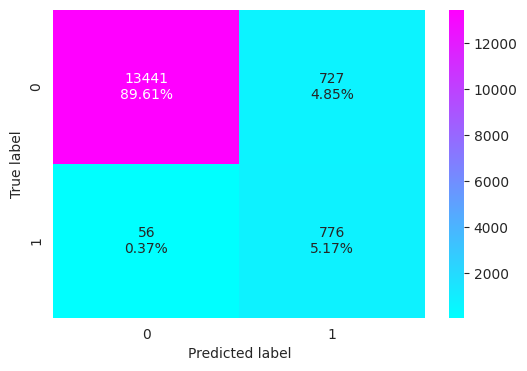

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_under_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
Random_Forest_grid_val_under = model_performance_classification_sklearn(
    Random_Forest_tuned_under_grid, X_val, y_val
)
Random_Forest_grid_val_under

,Accuracy,Recall,Precision,F1
0,0.9468,0.8777,0.5126,0.6472


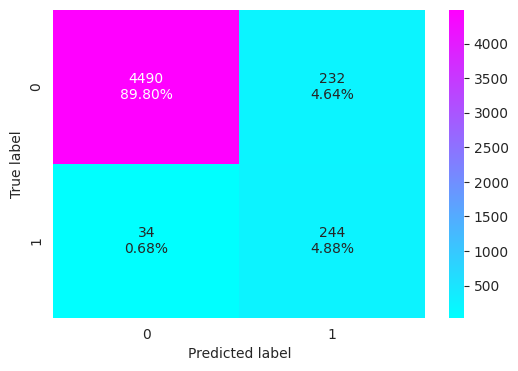

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_under_grid, X_val, y_val)

Training - Recall is good at 93.27%, but Precision is low at 51.63%. <br>
Validation - Recall is good at 87.77%, but Precision is low at 51.26%.

### Sample tuning method for Gradient Boost with undersampled data

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9014284683644759:


In [ ]:
# building model with best parameters
GB_tuned_under = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= 125,
    max_features= 0.5,
    learning_rate= 0.2,
)

# Fit the model on training data
GB_tuned_under.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [ ]:
## To check the performance on training set
GB_random_train_under = model_performance_classification_sklearn(
    GB_tuned_under, X_train, y_train
)
GB_random_train_under

,Accuracy,Recall,Precision,F1
0,0.9849,0.9543,0.8077,0.8749


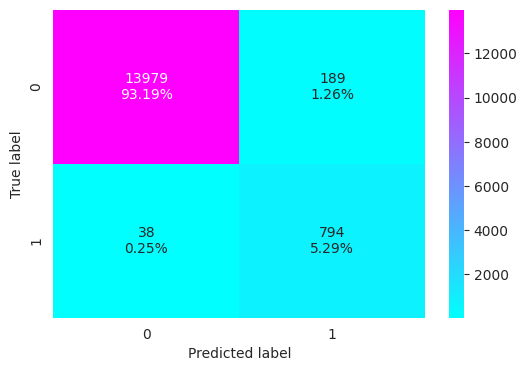

In [ ]:
confusion_matrix_sklearn(GB_tuned_under, X_train, y_train)

In [ ]:
## To check the performance on validation set
GB_random_val_under = model_performance_classification_sklearn(
    GB_tuned_under, X_val, y_val
)
GB_random_val_under

,Accuracy,Recall,Precision,F1
0,0.9782,0.8345,0.7864,0.8098


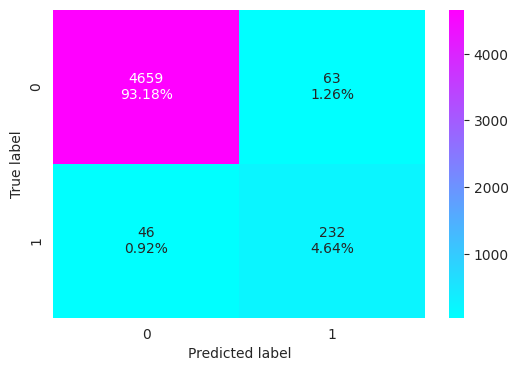

In [ ]:
confusion_matrix_sklearn(GB_tuned_under, X_val, y_val)

Train - All have decent rates. Recall rate is 95.43 and Precision is 80.77. Overfitting has been minimized. <br>
Validation - All have decent rates. Recall rate is 83.45 and Precision is 78.64. Overfitting has been minimized.

In [ ]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters are {'learning_rate': 0.2, 'max_features': 0.5, 'n_estimators': 125, 'subsample': 0.7} with CV score=0.7572685953394416:


In [ ]:
# building model with best parameters
GB_tuned_under_grid = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= 125,
    max_features= 0.5,
    learning_rate= 0.2,
)

# Fit the model on training data
GB_tuned_under_grid.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [ ]:
## To check the performance on training set
GB_grid_train_under = model_performance_classification_sklearn(
    GB_tuned_under_grid, X_train, y_train
)
GB_grid_train_under

,Accuracy,Recall,Precision,F1
0,0.9845,0.9567,0.8016,0.8723


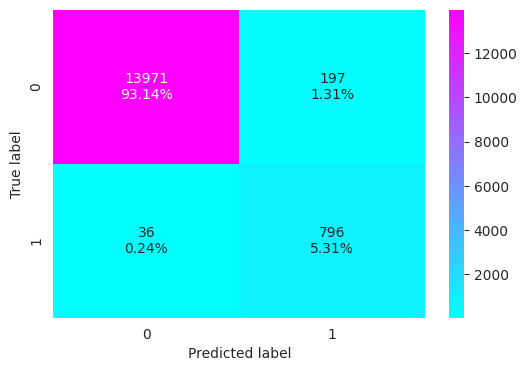

In [ ]:
confusion_matrix_sklearn(GB_tuned_under_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
GB_grid_val_under = model_performance_classification_sklearn(
    GB_tuned_under_grid, X_val, y_val
)
GB_grid_val_under

,Accuracy,Recall,Precision,F1
0,0.9804,0.8453,0.8103,0.8275


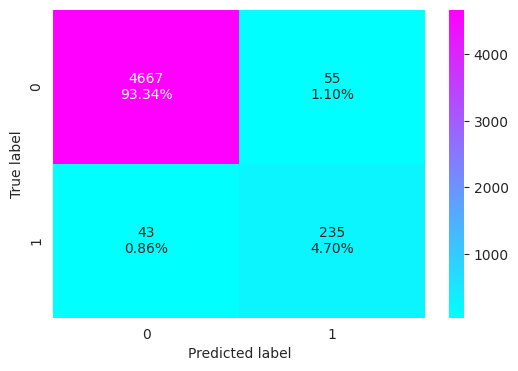

In [ ]:
confusion_matrix_sklearn(GB_tuned_under_grid, X_val, y_val)

Training - Accuracy is a little overfit but the rest of the rates look good.<br>
Validation - All rates are good. Recall rate is 84.53% and Precision is 81.03%.

### Sample tuning method for XG Boost with undersampled data

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=20, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9290743813577663:


In [ ]:
# building model with best parameters
XGB_tuned_under = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight = 5,
    n_estimators= 200,
    learning_rate= 0.1,
    gamma= 5
)

# Fit the model on training data
XGB_tuned_under.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## To check the performance on training set
XGB_random_train_under = model_performance_classification_sklearn(
    XGB_tuned_under, X_train, y_train
)
XGB_random_train_under

,Accuracy,Recall,Precision,F1
0,0.8759,0.9988,0.3088,0.4718


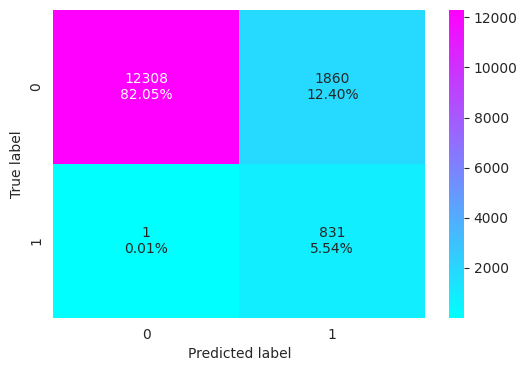

In [ ]:
confusion_matrix_sklearn(XGB_tuned_under, X_train, y_train)

In [ ]:
## To check the performance on validation set
XGB_random_val_under = model_performance_classification_sklearn(
    XGB_tuned_under, X_val, y_val
)
XGB_random_val_under

,Accuracy,Recall,Precision,F1
0,0.8808,0.9065,0.3066,0.4582


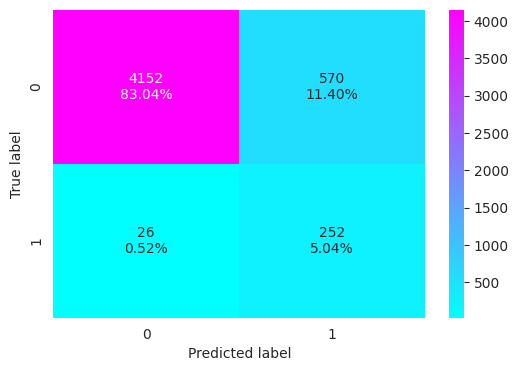

In [ ]:
confusion_matrix_sklearn(XGB_tuned_under, X_val, y_val)

Train - Recall is showing overfitting and the Precision rate is not acceptable at 30.88%. <br>
Validation - Recall rate is good, however the Precision rate is not acceptable at 45.82%. <br>

In [ ]:
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in GridCSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
            'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

#Fitting parameters in GridSearchCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters are {'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'scale_pos_weight': 10, 'subsample': 0.9} with CV score=0.8582136930957361:


In [ ]:
# building model with best parameters
XGB_tuned_under_grid = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight = 10,
    n_estimators= 200,
    learning_rate= 0.1,
    gamma= 3
)

# Fit the model on training data
XGB_tuned_under_grid.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## To check the performance on training set
XGB_grid_train_under = model_performance_classification_sklearn(
    XGB_tuned_under_grid, X_train, y_train
)
XGB_grid_train_under

,Accuracy,Recall,Precision,F1
0,0.8765,1.0000,0.3099,0.4731


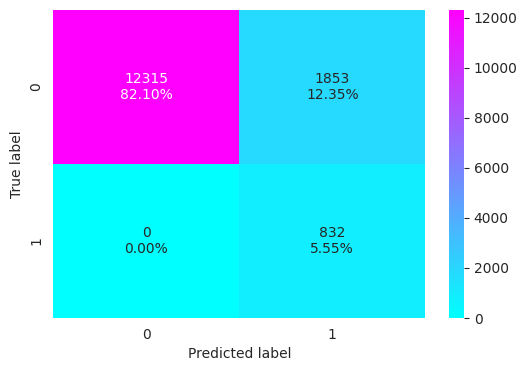

In [ ]:
confusion_matrix_sklearn(XGB_tuned_under_grid, X_train, y_train)

In [ ]:
## To check the performance on validation set
XGB_grid_val_under = model_performance_classification_sklearn(
    XGB_tuned_under_grid, X_val, y_val
)
XGB_grid_val_under

,Accuracy,Recall,Precision,F1
0,0.8872,0.9065,0.3190,0.4719


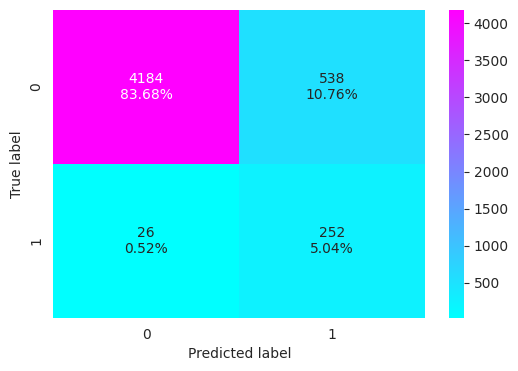

In [ ]:
confusion_matrix_sklearn(XGB_tuned_under_grid, X_val, y_val)

Training - Recall is overfitted and Precision has a rate of 30.99% which is not good.<br>
Validation - Recall rate is good, but the Precision rate is 31.90% which is not good at all.

## Model performance comparison and choosing the final model

In [ ]:
# Set the display format to show 4 decimal places
pd.options.display.float_format = '{:.4f}'.format

# Validation performance comparison

models_train_comp_df = pd.concat(
    [
        Random_Forest_random_train.T,
        Random_Forest_grid_train.T,
        GB_random_train.T,
        GB_grid_train.T,
        XGB_random_train.T,
        XGB_grid_train.T,
        Random_Forest_random_train_over.T,
        Random_Forest_grid_train_over.T,
        GB_random_train_over.T,
        GB_grid_train_over.T,
        XGB_random_train_over.T,
        XGB_grid_train_over.T,
        Random_Forest_random_train_under.T,
        Random_Forest_grid_train_under.T,
        GB_random_train_under.T,
        GB_grid_train_under.T,
        XGB_random_train_under.T,
        XGB_grid_train_under.T
        ],
    axis=1,
    )
models_train_comp_df.columns = [
    "Random Forest Tuned with Random Search",
    "Random Forest Tuned with Grid Search",
    "Gradient Boost Tuned with Random Search",
    "Gradient Boost Tuned with Grid Search",
    "XG Boost Tuned with Random Search",
    "XG Boost Tuned with Grid Search",
    "Random Forest Tuned with Oversampling with Random Search",
    "Random Forest Tuned with Oversampling with Grid Search",
    "Gradient Boost Tuned with Oversampling with Random Search",
    "Gradient Boost Tuned with Oversampling with Grid Search",
    "XG Boost with Oversampling with Random Search",
    "XG Boost with Oversampling with Grid Search",
    "Random Forest Tuned with Undersampling with Random Search",
    "Random Forest Tuned with Undersampling with Grid Search",
    "Gradient Boost Tuned with Undersampling with Random Search",
    "Gradient Boost Tuned with Undersampling with Grid Search",
    "XG Booat with Undersampling with Random Search",
    "XG Booat with Undersampling with Grid Search",
]
print("Training performance comparison:")
models_train_comp_df.transpose().round(4).style.set_table_styles([dict(selector="th", props=[('max-width', '150px')])])

Training performance comparison:


,Accuracy,Recall,Precision,F1
Random Forest Tuned with Random Search,0.994900,0.908700,1.000000,0.952100
Random Forest Tuned with Grid Search,0.990600,0.834100,0.995700,0.907800
Gradient Boost Tuned with Random Search,0.992700,0.908700,0.957000,0.932200
Gradient Boost Tuned with Grid Search,0.994500,0.914700,0.984500,0.948300
XG Boost Tuned with Random Search,0.999300,1.000000,0.987000,0.993400
XG Boost Tuned with Grid Search,0.999300,1.000000,0.987000,0.993400
Random Forest Tuned with Oversampling with Random Search,0.999900,1.000000,0.998800,0.999400
Random Forest Tuned with Oversampling with Grid Search,0.998300,0.998800,0.971900,0.985200
Gradient Boost Tuned with Oversampling with Random Search,0.994100,0.997600,0.905100,0.949100
Gradient Boost Tuned with Oversampling with Grid Search,0.985500,0.948300,0.818500,0.878600


- Every model is showing overfitting in either Accuracy or Recall. <br>

- Gradient Boost Tuned with Undersampling model using Grid search. It has a recall of 95.43%. The values for Precision is 98.49%, F1 is 87.49%. Accuracy is showing a rate of 98.49%, which is slightly overfit but not terrible when looking at everything as a whole. <br>


In [ ]:
# Set the display format to show 4 decimal places
pd.options.display.float_format = '{:.4f}'.format

# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        Random_Forest_random_val.T,
        Random_Forest_grid_val.T,
        GB_random_val.T,
        GB_grid_val.T,
        XGB_random_val.T,
        XGB_grid_val. T,
        Random_Forest_random_val_over.T,
        Random_Forest_grid_val_over.T,
        GB_random_val_over.T,
        GB_grid_val_over.T,
        XGB_random_val_over.T,
        XGB_grid_val_over.T,
        Random_Forest_random_val_under.T,
        Random_Forest_grid_val_under.T,
        GB_random_val_under.T,
        GB_grid_val_under.T,
        XGB_random_val_under.T,
        XGB_grid_val_under.T
        ],
    axis=1,
    )
models_val_comp_df.columns = [
    "Random Forest Tuned with Random Search",
    "Random Forest Tuned with Grid Search",
    "Gradient Boost Tuned with Random Search",
    "Gradient Boost Tuned with Grid Search",
    "XG Boost Tuned with Random Search",
    "XG Boost Tuned with Grid Search",
    "Random Forest Tuned with Oversampling with Random Search",
    "Random Forest Tuned with Oversampling with Grid Search",
    "Gradient Boost Tuned with Oversampling with Random Search",
    "Gradient Boost Tuned with Oversampling with Grid Search",
    "XG Boost with Oversampling with Random Search",
    "XG Boost with Oversampling with Grid Search",
    "Random Forest Tuned with Undersampling with Random Search",
    "Random Forest Tuned with Undersampling with Grid Search",
    "Gradient Boost Tuned with Undersampling with Random Search",
    "Gradient Boost Tuned with Undersampling with Grid Search",
    "XG Booat with Undersampling with Random Search",
    "XG Booat with Undersampling with Grid Search",
]
print("Validation performance comparison:")
# Wrap column names
models_val_comp_df.transpose().round(4).style.set_table_styles([dict(selector="th", props=[('max-width', '150px')])])

Validation performance comparison:


,Accuracy,Recall,Precision,F1
Random Forest Tuned with Random Search,0.986000,0.762600,0.981500,0.858300
Random Forest Tuned with Grid Search,0.986000,0.777000,0.964300,0.860600
Gradient Boost Tuned with Random Search,0.973400,0.737400,0.773600,0.755100
Gradient Boost Tuned with Grid Search,0.972200,0.755400,0.747300,0.751300
XG Boost Tuned with Random Search,0.987200,0.805800,0.957300,0.875000
XG Boost Tuned with Grid Search,0.987200,0.805800,0.957300,0.875000
Random Forest Tuned with Oversampling with Random Search,0.988000,0.809400,0.969800,0.882400
Random Forest Tuned with Oversampling with Grid Search,0.986800,0.823700,0.930900,0.874000
Gradient Boost Tuned with Oversampling with Random Search,0.969600,0.802200,0.696900,0.745800
Gradient Boost Tuned with Oversampling with Grid Search,0.979800,0.838100,0.806200,0.821900


- XGBoost with Undersampling modul using random or grid search, however both are showing Precision of 30.66% and 31.90% for Precision which is not good at all. <br>

- The next best - that has a good recall and precision rate -  is Gradient Boost Tuned with Undersampling model using Grid search. It has a recall of 84.53%. The values for Precision is 81.03%, F1 is 82.75%. Accuracy is showing a rate of 98.04%, which is slightly overfit but not terrible when looking at everything as a whole. <br>

- All the models are showing some overfitting. XGBoost with undersampling Random and Grid Search, Random Forrest with undersampling Random and Grid Search are showing the least amount of overfitting but their Precision is low which makes them not good models.


In [ ]:
# joins the validation and test dataset together to make a DataFrame that is easier to interpret
model_train_val_perf_comp = models_train_comp_df.join(
    models_val_comp_df, lsuffix="_train", rsuffix="_val"
)


# code will combine train and validation columns together later on to easier interpret data
model_train_val_perf_comp.transpose()

,Accuracy,Recall,Precision,F1
Random Forest Tuned with Random Search_train,0.9949,0.9087,1.0000,0.9521
Random Forest Tuned with Grid Search_train,0.9903,0.8269,0.9985,0.9047
Gradient Boost Tuned with Random Search_train,0.9927,0.9087,0.9570,0.9322
Gradient Boost Tuned with Grid Search_train,0.9945,0.9147,0.9845,0.9483
XG Boost Tuned with Random Search_train,0.9993,1.0000,0.9870,0.9934
XG Boost Tuned with Grid Search_train,0.9993,1.0000,0.9870,0.9934
Random Forest Tuned with Oversampling with Random Search_train,0.9999,1.0000,0.9988,0.9994
Random Forest Tuned with Oversampling with Grid Search_train,0.9985,0.9988,0.9754,0.9869
Gradient Boost Tuned with Oversampling with Random Search_train,0.9941,0.9976,0.9051,0.9491
Gradient Boost Tuned with Oversampling with Grid Search_train,0.9855,0.9483,0.8185,0.8786


**Observations:**
* Accuracy seems to generalize well on all models. Shows slight overfitting on some of the models in the training and validation.<br>
* Recall is the best on Gradient Boost Tuned with Undersampling using Grid Search. Random Forest Tuned with Undersampling and XG Booat with Undersampling have good Recall rates but their precision rates are low. <br>
* Precision is the best on Random Forest Tuned with Grid Search, Random Forest Tuned with OverOversampling with Random Search, and Gradient Boost with Oversampling with Grid Search. XGBoost with Undersampling (both Random and Grid) and Random Forest with Undersampling (both Random and Grid) have very poor rates. <br>
* F1 is the best on Random Forest Tuned with Oversampling (Random and Grid Search), XG Boost Tuned, XG Boost with Oversampling. XXGBoost with Undersampling (Random and Grid Search) and Random Forest with Oversampling (Random and Grid Search) have very poor rates.

**Estimated costs:**

**Maintenance cost** = TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost) where, <br>

* Replacement cost = 40,000 dollars <br>
* Repair cost = 15,000 dollars <br>
* Inspection cost = 5,0000 dollars <br>

**Calculate total service cost** <br>

- The total service cost it would take for each model will be calculated as follows: <br>
    - For false positives, the model incorrectly predicts that the generator will fail. As a result, a technician inspects the generator and finds no issues, incurring a cost of $5,000 each time.<br>
    - For False Negatives, the model incorrectly predicts that the generator will not fail, but it actually does. Consequently, a technician must replace the generator, incurring a cost of $40,000 each time. <br>
    - For True Positives, the model correctly predicts that the generator will fail. Consequently, a technician inspects and repairs the generator, incurring a total cost of $20,000 ($5,000 for inspection and $15,000 for repair).<br>

The value of this ratio will range between 0 and 1. The ratio will be 1 only when the maintenance cost of the model equals the minimum possible maintenance cost.. <br>




In [ ]:
def calculate_total_cost(model, predictors, targets):
    """
    Calculates the total cost of each model based on the following:
    Replacement cost = $40,000
    Repair cost = $15,000
    Inspection cost = $5,000

    model: model used to calculate generator failure
    predictors: independant variables
    targets: dependant variable
    """
    #     creates a flattened confusion matrix
    cm_flat = confusion_matrix(targets, model.predict(predictors)).flatten()
    Inspection_Cost = cm_flat[1] * 5000  # calculates total cost for False Positives
    Replacement_Cost = cm_flat[2] * 40000  # calculates total cost for False Negatives
    Repair_Cost = cm_flat[3] * 20000  # calculates total cost for True Positives

    #     sums up total service cost of False Positives, False Negatives, and True Positives
    total_cost = Repair_Cost + Replacement_Cost + Inspection_Cost
    return total_cost

In [ ]:
# creates DataFrame containing the total estomated service cost for each tuned predicitve model
df_total_cost_per_model = pd.DataFrame(
    [
        calculate_total_cost(Random_Forest_tuned, X_val, y_val),
        calculate_total_cost(Random_Forest_tuned_grid, X_val, y_val),
        calculate_total_cost(GB_tuned, X_val, y_val),
        calculate_total_cost(GB_tuned_grid, X_val, y_val),
        calculate_total_cost(XGB_tuned, X_val, y_val),
        calculate_total_cost(XGB_tuned_grid, X_val, y_val),
        calculate_total_cost(Random_Forest_tuned_over, X_val, y_val),
        calculate_total_cost(Random_Forest_tuned_over_grid, X_val, y_val),
        calculate_total_cost(GB_tuned_over, X_val, y_val),
        calculate_total_cost(GB_tuned_over_grid, X_val, y_val),
        calculate_total_cost(XGB_tuned_over, X_val, y_val),
        calculate_total_cost(XGB_tuned_over_grid, X_val, y_val),
        calculate_total_cost(Random_Forest_tuned_under, X_val, y_val),
        calculate_total_cost(Random_Forest_tuned_under_grid, X_val, y_val),
        calculate_total_cost(GB_tuned_over, X_val, y_val),
        calculate_total_cost(GB_tuned_over_grid, X_val, y_val),
        calculate_total_cost(XGB_tuned_under, X_val, y_val),
        calculate_total_cost(XGB_tuned_under_grid, X_val, y_val),

    ],
    index=[
         "Random Forest Tuned with Random Search",
         "Random Forest Tuned with Grid Search",
         "Gradient Boost Tuned with Random Search",
         "Gradient Boost Tuned with Grid Search",
         "XG Boost Tuned with Random Search",
         "XG Boost Tuned with Grid Search",
         "Random Forest Tuned with Oversampling with Random Search",
         "Random Forest Tuned with Oversampling with Grid Search",
         "Gradient Boost Tuned with Oversampling with Random Search",
         "Gradient Boost Tuned with Oversampling with Grid Search",
         "XG Boost with Oversampling with Random Search",
         "XG Boost with Oversampling with Grid Search",
         "Random Forest Tuned with Undersampling with Random Search",
         "Random Forest Tuned with Undersampling with Grid Search",
         "Gradient Boost Tuned with Undersampling with Random Search",
         "Gradient Boost Tuned with Undersampling with Grid Search",
         "XG Booat with Undersampling with Random Search",
         "XG Booat with Undersampling with Grid Search",
    ],  # sets index names
    columns=["Total Service Cost"],  # sets column names
)
df_total_cost_per_model

,Total Service Cost
Random Forest Tuned with Random Search,6900000
Random Forest Tuned with Grid Search,6840000
Gradient Boost Tuned with Random Search,7320000
Gradient Boost Tuned with Grid Search,7275000
XG Boost Tuned with Random Search,6690000
XG Boost Tuned with Grid Search,6690000
Random Forest Tuned with Oversampling with Random Search,6655000
Random Forest Tuned with Oversampling with Grid Search,6625000
Gradient Boost Tuned with Oversampling with Random Search,7145000
Gradient Boost Tuned with Oversampling with Grid Search,6740000


**Based on cost:**

1.	XG Boost with Oversampling with Grid Search
2.	Random Forest Tuned with Oversampling with Grid Search
3.	Random Forest Tuned with Oversampling with Random Search
4.	XG Boost with Oversampling with Random Search
5.	XG Boost Tuned with Random Search
6.	XG Boost Tuned with Grid Search
7.	Gradient Boost Tuned with Oversampling with Grid Search
8.	Gradient Boost Tuned with Undersampling with Grid Search
9.	Random Forest Tuned with Grid Search
10.	Random Forest Tuned with Random Search
11.	 Gradient Boost Tuned with Oversampling with Random Search
12.	Gradient Boost Tuned with Undersampling with Random Search
13.	Gradient Boost Tuned with Grid Search
14.	Gradient Boost Tuned with Random Search
15.	Random Forest Tuned with Undersampling with Grid Search
16.	Random Forest Tuned with Undersampling with Random Search
17.	XG Booat with Undersampling with Grid Search
18.	XG Booat with Undersampling with Random Search



**Best Recommended Model:**

Even though it does not have the best Recall or Precision rate, XGBoost with Oversampling with Grid Search is the best model overall.
* Estimated cost would be 6,595,000.
* Accuracy rate 99.26% on training, 98.38% on validation.
* Recall 100% on training, 84.89% on validation.
* Precision 88.23% on training, 85.82% on validation.
* F1 93.75% on training, 85.35% on validation.

**2nd Best Model:**
Random Forest with Oversampling with Grid Search is the best model overall.
* Estimated cost would be 6,625,000.
* Accuracy rate 99.83% on training, 98.68% on validation.
* Recall 99.83% on training, 82.37% on validation.
* Precision 87.19% on training, 93.09% on validation.
* F1 98.52% on training, 87.40% on validation.

### Test set final performance

Testing XG Boost with Oversampling with Grid Search (best total cost), Random Forest with Oversampling Grid Search (2nd best total cost), Random Forest Tuning with Random Search (best Precision), and Gradient Boost Tuned with Undersampling with Grid Search (best Recall) before making a final recommendation.

In [ ]:
# Calculating different metrics on the test set
xgb_over_random_test = model_performance_classification_sklearn(XGB_tuned_over_grid, X_test, y_test)
print("Test performance:")
xgb_over_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.9590,0.8723,0.5928,0.7059


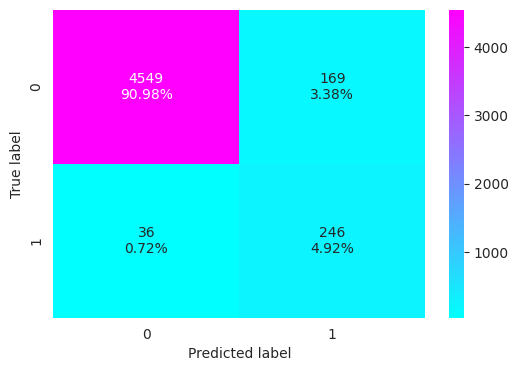

In [ ]:
confusion_matrix_sklearn(XGB_tuned_over_grid, X_test, y_test)

In [ ]:
print(
    "Total service cost for tuned XGBoost Tuned with Oversampling with Grid Search on test data: ${:,}".format(
        calculate_total_cost(XGB_tuned_over_grid, X_test, y_test)
    ),
)

Total service cost for tuned XGBoost Tuned with Oversampling with Grid Search on test data: $7,205,000


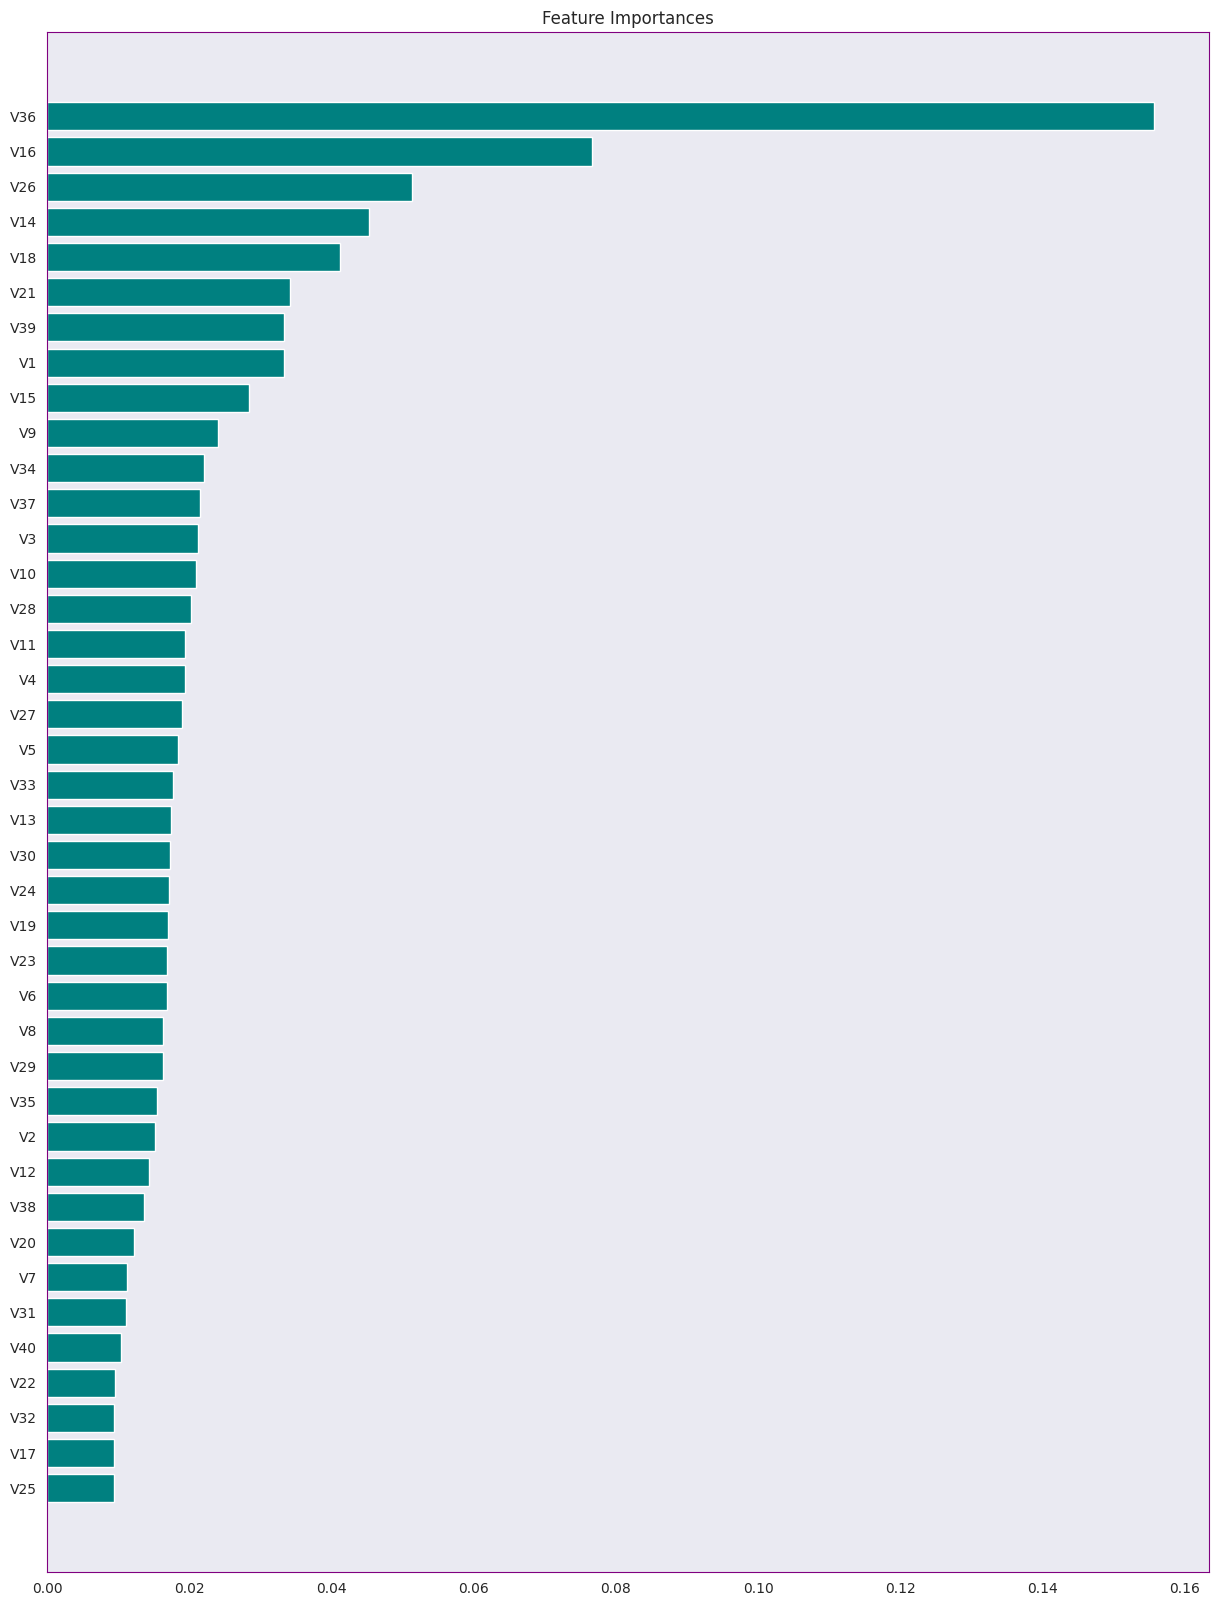

In [ ]:
feature_names = X.columns
importances = XGB_tuned_over_grid.feature_importances_
indices = np.argsort(importances)

# creates plot showing model feature importance
plt.figure(figsize=(15, 20))  # sets figure size
plt.barh(
    y=range(len(indices)), width=importances[indices], color="teal"
)  # creates bars for plot
plt.title("Feature Importances")  # sets title
plt.yticks(
    ticks=range(len(feature_names)), labels=[feature_names[i] for i in indices]
)  # sets y ticks as individual features


plt.show()

Recall 87.23% is good but Precision 59.28% is low. Estimated cost is $7,205,000.

In [ ]:
# Calculating different metrics on the test set
random_forest_over_grid_test = model_performance_classification_sklearn(Random_Forest_tuned_over_grid, X_test, y_test)
print("Test performance:")
random_forest_over_grid_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.9752,0.8085,0.7651,0.7862


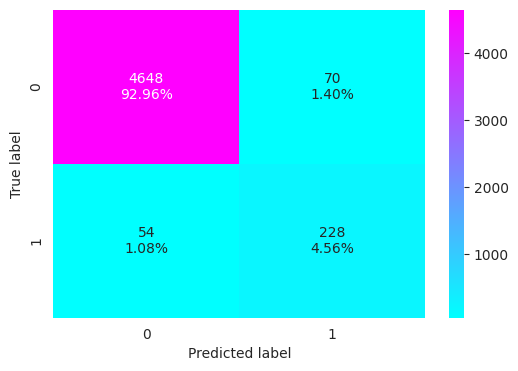

In [ ]:
confusion_matrix_sklearn(Random_Forest_tuned_over_grid, X_test, y_test)

In [ ]:
print(
    "Total service cost for tuned Random Forest Tuned with Oversampling with Grid Search on test data: ${:,}".format(
        calculate_total_cost(Random_Forest_tuned_over_grid, X_test, y_test)
    ),
)

Total service cost for tuned Random Forest Tuned with Oversampling with Grid Search on test data: $7,070,000


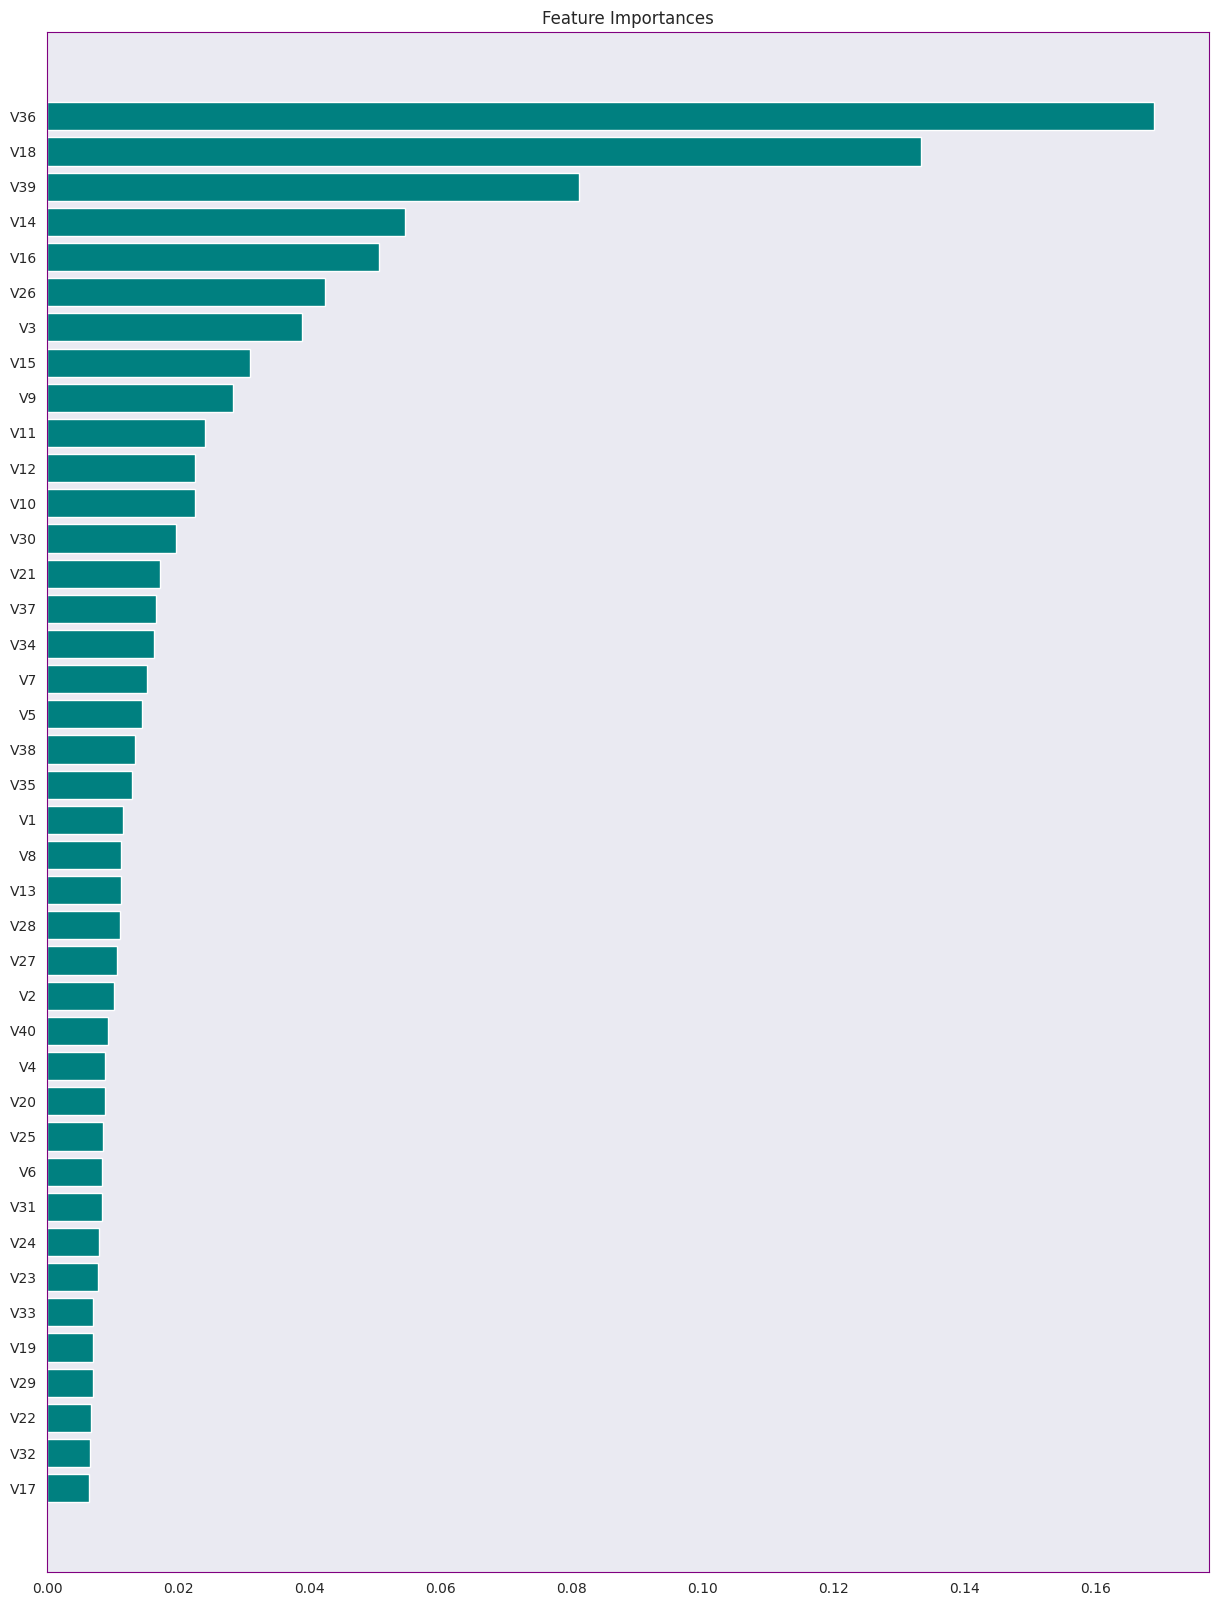

In [ ]:
feature_names = X.columns
importances = Random_Forest_tuned_over_grid.feature_importances_
indices = np.argsort(importances)

# creates plot showing model feature importance
plt.figure(figsize=(15, 20))  # sets figure size
plt.barh(
    y=range(len(indices)), width=importances[indices], color="teal"
)  # creates bars for plot
plt.title("Feature Importances")  # sets title
plt.yticks(
    ticks=range(len(feature_names)), labels=[feature_names[i] for i in indices]
)  # sets y ticks as individual features


plt.show()

Recall 80.85% is good but Precision 76.51% is ok. Estimated cost is $7,070,000.

In [ ]:
# Calculating different metrics on the test set
random_forest_random_test = model_performance_classification_sklearn(Random_Forest_tuned, X_test, y_test)
print("Test performance:")
random_forest_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.9834,0.7943,0.8996,0.8437


In [ ]:
print(
    "Total service cost for tuned Random Forest Tuned on test data: ${:,}".format(
        calculate_total_cost(Random_Forest_tuned, X_test, y_test)
    ),
)


Total service cost for tuned Random Forest Tuned on test data: $6,925,000


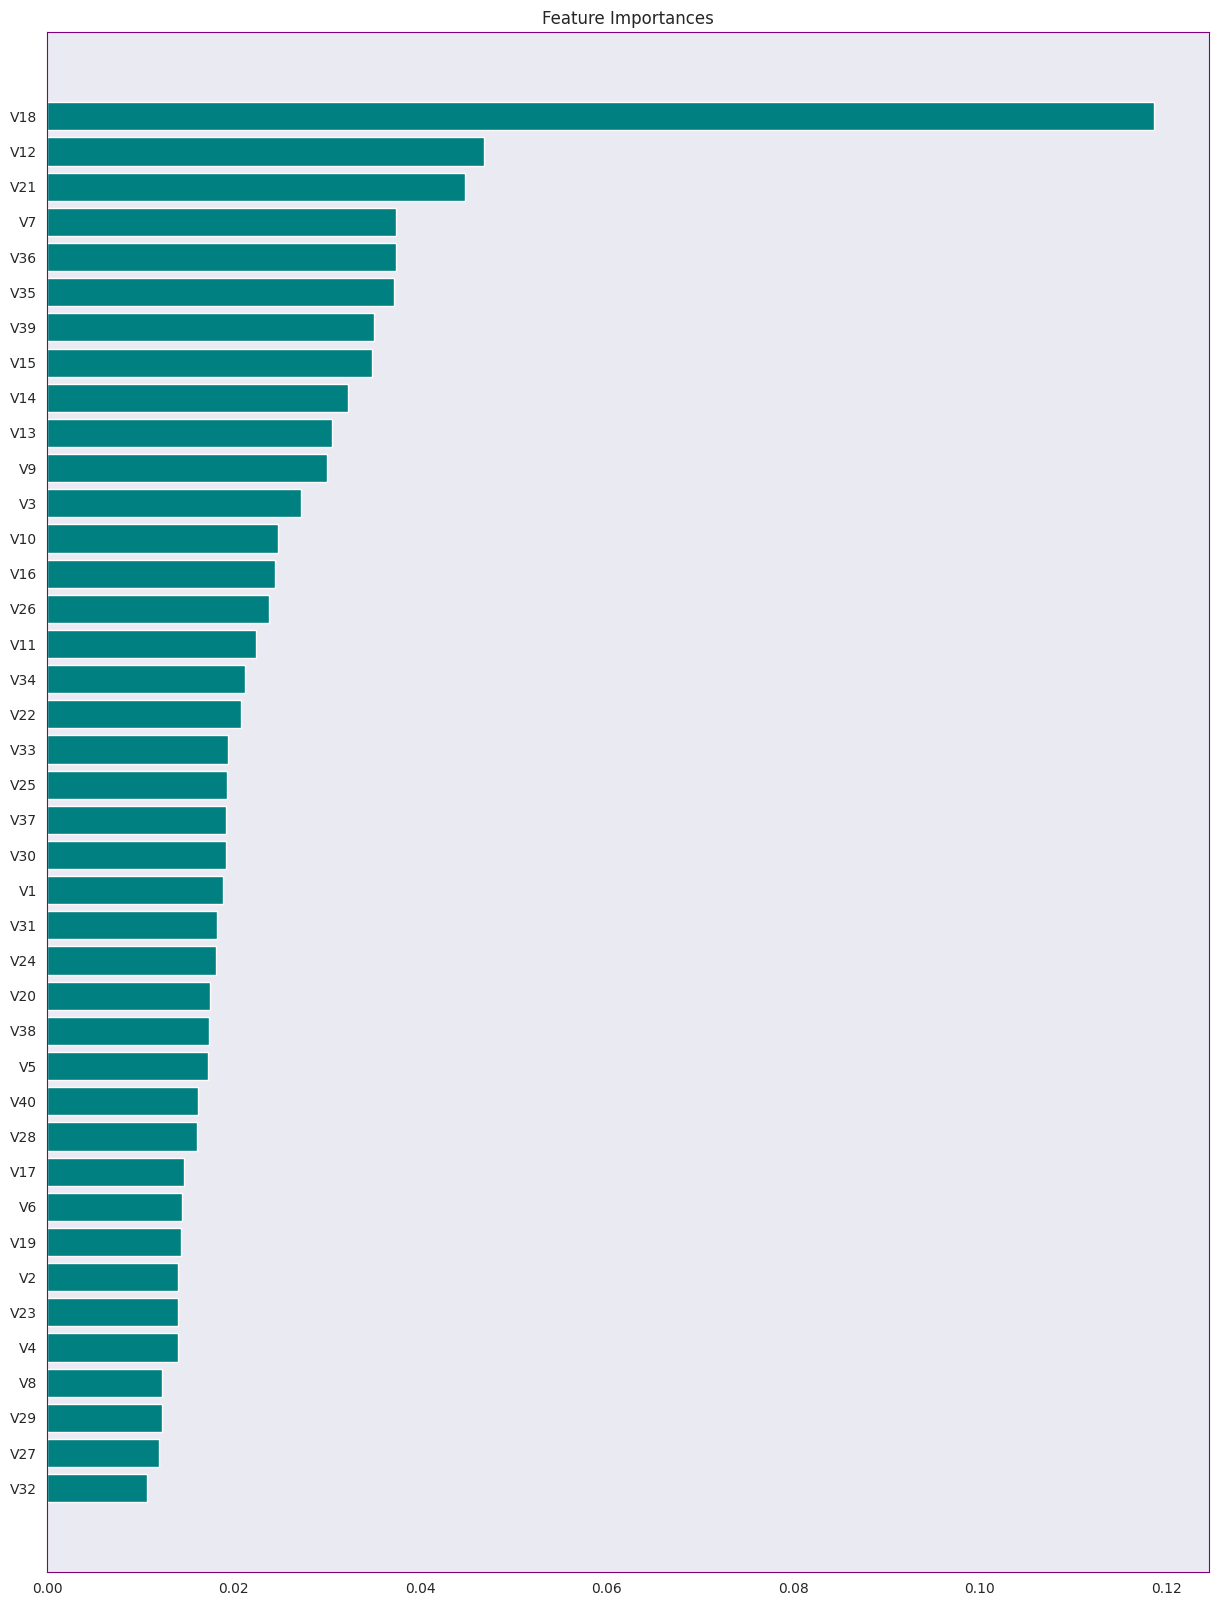

In [ ]:
feature_names = X.columns
importances = Random_Forest_tuned.feature_importances_
indices = np.argsort(importances)

# creates plot showing model feature importance
plt.figure(figsize=(15, 20))  # sets figure size
plt.barh(
    y=range(len(indices)), width=importances[indices], color="teal"
)  # creates bars for plot
plt.title("Feature Importances")  # sets title
plt.yticks(
    ticks=range(len(feature_names)), labels=[feature_names[i] for i in indices]
)  # sets y ticks as individual features


plt.show()

Recall 79.43% is good but Precision 89.96% is low. Estimated cost is $6,925,000.

In [ ]:
# Calculating different metrics on the test set
GB_under_grid_test = model_performance_classification_sklearn(GB_tuned_under_grid, X_test, y_test)
print("Test performance:")
GB_under_grid_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.9472,0.8333,0.5199,0.6403


In [ ]:
print(
    "Total service cost for tuned Gradient Boost Tuned with Undersampling with Grid Search on test data: ${:,}".format(
        calculate_total_cost(GB_tuned_under_grid, X_test, y_test)
    ),
)


Total service cost for tuned Gradient Boost Tuned with Undersampling with Grid Search on test data: $7,665,000


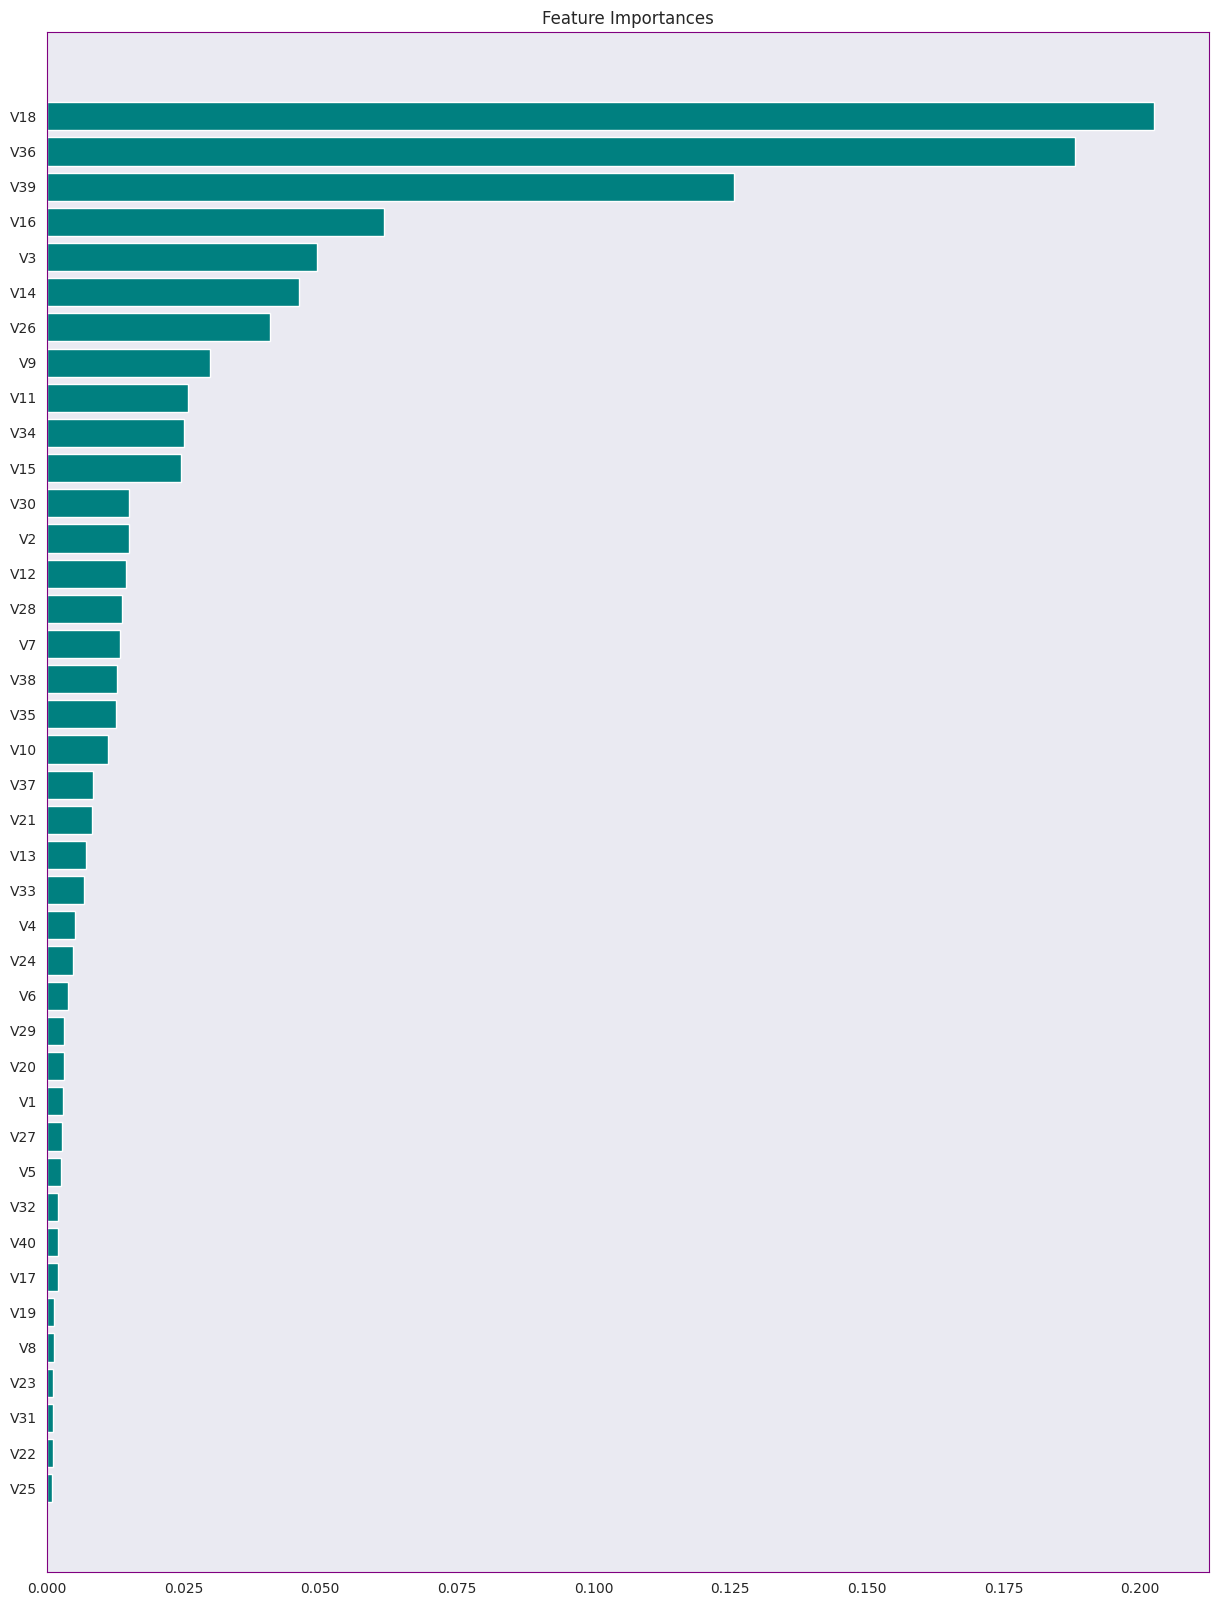

In [ ]:
feature_names = X.columns
importances = GB_tuned_under_grid.feature_importances_
indices = np.argsort(importances)

# creates plot showing model feature importance
plt.figure(figsize=(15, 20))  # sets figure size
plt.barh(
    y=range(len(indices)), width=importances[indices], color="teal"
)  # creates bars for plot
plt.title("Feature Importances")  # sets title
plt.yticks(
    ticks=range(len(feature_names)), labels=[feature_names[i] for i in indices]
)  # sets y ticks as individual features


plt.show()

Recall 83.33% is good but Precision 51.99% is low. Estimated cost is $7,665,000.

**Observations:**

Best Model appears to be the Random Forest Tuned with Random Search model.

**Based on test data:**
* Estimated cost is $6,925,000.
* Accuracy 98.34%
* Recall 79.43%
* Precision 89.96%
* F1 84.37%

The feature importances showed that sensor V18 by far is the most important sensor when determining the failure of the generator.

## Pipelines to build the final model


In [ ]:
# creates list of features to transform
col_list = [
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
    "V7",
    "V8",
    "V9",
    "V10",
    "V11",
    "V12",
    "V13",
    "V14",
    "V15",
    "V16",
    "V17",
    "V18",
    "V19",
    "V20",
    "V21",
    "V22",
    "V23",
    "V24",
    "V25",
    "V26",
    "V27",
    "V28",
    "V29",
    "V30",
    "V31",
    "V32",
    "V33",
    "V34",
    "V35",
    "V36",
    "V37",
    "V38",
    "V39",
    "V40",
]

MinMax_transformer = make_pipeline(MinMaxScaler())

# sets transformer as KNNImputer for the ColumnTransformer
KNN_transformer = make_pipeline(KNNImputer(n_neighbors=10))

# sets ColumnTransfomer as preprocessor to impute model features using KNN
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", MinMax_transformer, col_list),
        ("imputer", KNN_transformer, col_list),
    ],
    remainder="passthrough",
)


In [ ]:
X_train_pipeline = X_train
y_train_pipeline = y_train

X_test_pipeline = X_test
y_test_pipeline = y_test

In [ ]:
# sets pipeline as name model
model = Pipeline(
    steps=[
        ("pre", preprocessor),  # Imputes missing values with KNNImputer
        (
            "Random Forest",
            RandomForestClassifier(
                n_estimators= 300,
                min_samples_leaf= 1,
                max_samples= 0.6,
                max_features= 'sqrt',
            ),  # the model being used in the pipeline
        ),
    ]
)

model.fit(X_train_pipeline, y_train_pipeline)  # fits the model to the training data

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28', 'V29',
                                                   'V30', ...]),
                                                 ('imputer',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=10))]),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28', 'V29',
                                                   'V30', ...])])),
                ('Random Forest',
                 RandomForestClassifier(max_samples=0.6, n_estimators=300))])

In [ ]:
model.predict(X_test_pipeline)  # predicts the model with the testing data

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
model_performance_classification_sklearn(model, X_test_pipeline, y_test_pipeline)

,Accuracy,Recall,Precision,F1
0,0.9796,0.7766,0.8488,0.8111


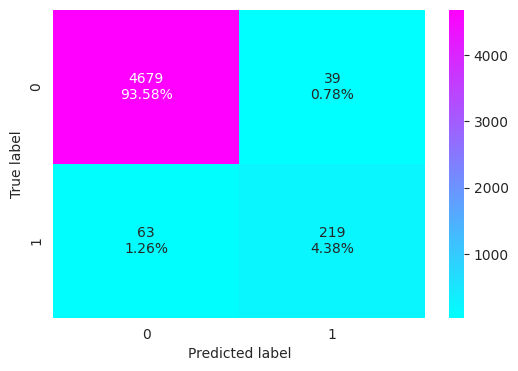

In [ ]:
confusion_matrix_sklearn(model, X_test_pipeline, y_test_pipeline)

In [ ]:
print(
    "Total service cost for tuned XGBoost on test data: ${:,}".format(
        calculate_total_cost(model, X_test_pipeline, y_test_pipeline)
    ),
)

Total service cost for tuned XGBoost on test data: $7,095,000


Estimated production total service cost is 7,095,000. <br>
The pipeline is showing Accuracy of 97.96%, Recall of 77.66%, Precision of 84.88%, and F1 81.11%.

# Business Insights and Conclusions

* After developing 18 different machine learning models, we selected the final model, Random Forest Tuned with Random Search. We addressed the target class imbalance (few 'failures' and many 'no failures') and optimized the model's performance using hyperparameter tuning and cross-validation. By testing with original, undersampled, and oversampled data, and employing a pipeline, we developed the most effective model possible with the available data.

* Random Forest Tuned with Random Search.
  * Accuracy 98.34%
  * Recall 79.43%
  * Precision 89.96%
  * F1 84.37%. <br>

* The data showed that the generator did not fail in 94.36% of cases and failed in 5.64% of cases. <br>
* The Model predicted correctly 98.43%. That is a pretty good percentage. However the recall rate is 79.43%, more work should be done to improve this percentage.
* The total estimated service cost for the best model is expected to range between approximately 6,925,000 dollars (development estimate) and 7,095,000 dollars (production estimate). <br>


**Top 5 sensors to watch:**
1. V18
2. V12
3. V21
4. V7
5. V36

* These key attributes are essential for distinguishing between failures and non-failures. Leveraging this information to collect sensor data more frequently will enhance the machine learning model and lower maintenance costs. By acquiring additional data, we can create a more robust and generalized model that improves the prediction of generator failures and significantly reduces overall service costs.
* Most sensors exhibit an inverse relationship with the failure rate. If a sensor’s average value is positive during a generator failure, it tends to be negative when there is no failure, and vice versa for some sensors. This inverse relationship is generally reliable
* To detect failures, monitor sensor V18 closely. If the sensor drops below 0, dispatch a technician to inspect the generator. This proactive approach should allow sufficient time to repair the generator before it fails and requires replacement.
* Each sensor exhibited a normal distribution in its readings.


***

In [17]:
%%shell
jupyter nbconvert --to html //'/content/drive/MyDrive/Python_Course/Project_6/MT_Project_LearnerNotebook_FullCode_Updated.ipynb'

[NbConvertApp] Converting notebook ///content/drive/MyDrive/Python_Course/Project_6/MT_Project_LearnerNotebook_FullCode_Updated.ipynb to html
[NbConvertApp] Writing 4388876 bytes to /content/drive/MyDrive/Python_Course/Project_6/MT_Project_LearnerNotebook_FullCode_Updated.html
